<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-2_ArcFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArcFace Loss (Additive Angular Margin Loss)

## Теория ArcFace

В случае с обучением на задачу классификации первая подходящая лосс-функция, которая нам приходит в голову — Cross-Entropy. И на ней действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые трюки, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших подходов считается ArcFace (Additive Angular Margin).


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными доп. атрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация приводит к тому, что эмбеддинги распределяются по сфере единичного радиуса (и сфере радиуса s после умножения на гиперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угол между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.

![ArcFace](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKRR-YA_XR3yhIYBbkc8Zlbua0Q2WdM3gx_g&s)

**Важное пояснение:**

Строго говоря, ArcFace - не лосс, отдельный архитектурный модуль модификация SoftMax. Он реализует идею внесения геометрического отступа непосредственно в пространство признаков. Для обучения в качестве лосса используется обычная кросс-энтропия. Более конкретно по шагам:

1. Вы извлекаете эмбеддинги из бэкбона сети (предобученной модели, у которой обрезан FC-слой, если он был)
2. Эти эмбеддинги поступают в ArcFace-слой, который содержит векторы-центры для каждого класса (веса классификатора) и логику нормализации и добавления углового отступа
3. Для целевого класса ArcFace-слой преобразует косинус угла $\theta$ в $cos(\theta + m)$
4. Для остальных классов оставляет обычный косинус $cos(\theta)$
5. Эти модифицированные логиты подаются на вход стандартной функции Cross-Entropy
6. Градиенты от Cross-Entropy текут назад через ArcFace-слой к бэкбону, обучая модель извлекать эмбеддинги

Результат: модифицированные логиты с "жестким" разделением для целевого класса, а значит и более качественные эмбеддинги.

Схема:
```
[Изображение] → [Бэкбон] → [ЭМБЕДДИНГ] → [ArcFace] → [Логиты] → [CE Loss]
                    │                        │           │          
                   CNN                   Нормализация   Оценки
                                          + Angular    для всех
                                            Margin     классов
```

Для получения качественных эмбеддингов после обучения ArcFace-слой больше не нужен, и его обычно обрезают. Он нужен был только обучения модели, и поэтому часто ArcFace называю именно лоссом. Но стоит всегда держать в голове, что это некоторое упрощение, которое нужно лишь для того, чтобы проще формулировать мысли.

**Доп. литература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

## Другие лоссы

Кроме ArcFace, есть еще много разных вариантов лоссов для задачи Face Recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте в качестве дополнительного задания.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Иногда так выходит лучше, чем если обучать на каком-то одном лоссе.

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/15zuNdOupRFnG7oE-rFj9FsjoNTK6DYn5).

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

Воспользуемся датасетом, который мы разработали в ноутбуке обучения Face Alignment: https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-1_FaceAlignment.ipynb

In [1]:
import numpy as np

In [372]:
%run celeba_dataset/faces_dataset.py

In [496]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torchvision.transforms as transforms
import kagglehub
import json
from torchvision.transforms import v2
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# В качестве бэкбона у нас имаджнет, так что нормализовать надо с их параметрами
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

# Предсказанные нашей моделью лэндмарки
pred_landmarks_df = pd.read_csv('celeba_dataset/fr/predicted_landmarks.csv', index_col='image_id')
# Улучшенные bbox лиц для диких картинок
bbox_df = pd.read_csv('celeba_dataset/list_bbox_celeba_better.csv', index_col='image_id')
dataset_name = 'kevinpatel04/celeba-original-wild-images'
source_dir = kagglehub.dataset_download(dataset_name)

class FaceRecognitionDataset(FacesDataset):
    def __init__(self,
                 mode='train',
                 transform=None,
                 identities=None, # Добавлен параметр identities
                 cache_dir='cache_cd'):
        """
        Инициализирует датасет для распознавания лиц.

        Args:
            mode (str): Режим работы датасета ('train', 'val', 'test').
            transform (callable, optional): Необязательные преобразования, применяемые к изображению.
            identities (list, optional): Список идентификаторов, которые должны быть включены в датасет.
                                        Если передан, датасет будет содержать только изображения этих идентичностей,
                                        и их метки будут переназначены по порядку.
        """

        # Загружаем identity_df для текущего режима
        current_mode_identity_df = pd.read_csv(f'celeba_dataset/fr/{mode}_25_frontal_df.csv', index_col="image_id")

        if identities is None:
            # If no specific identities are provided, use all unique identities in the current mode
            all_unique_identities = current_mode_identity_df['identity'].unique()
        else:
            # Otherwise, use the provided identities
            all_unique_identities = identities

        # Filter dataframe to include only specified identities
        self.identity_df = current_mode_identity_df[current_mode_identity_df['identity'].isin(all_unique_identities)].copy()

        # Use LabelEncoder to map identities to 0-indexed labels
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(sorted(all_unique_identities)) # Fit on sorted unique identities for consistent mapping

        # Store the 0-indexed labels directly in the dataframe for easy access
        self.identity_df['label'] = self.label_encoder.transform(self.identity_df['identity'])

        self.num_classes = len(self.label_encoder.classes_)

        files = self.identity_df.index.tolist()

        # Определяем атрибуты для FacesDataset
        attribs_dict = {
            "landmarks": pred_landmarks_df,
            "bbox": bbox_df
        }

        if transform is None:
            if mode == 'train':
                transform = [
                    v2.RandomHorizontalFlip(p=0.5), # Зеркальное отображение по горизонтали
                    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Яркость, контрастность, насыщенность, оттенок
                    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.1), # Гауссовский шум (небольшое размытие как форма шума)
                    v2.RandomApply([v2.RandomAffine(degrees=0, translate=(0.02, 0.02), scale=(0.98, 1.02), shear=0, interpolation=v2.InterpolationMode.BILINEAR)], p=0.2),
                    v2.RandomGrayscale(p = 0.2),
                    v2.RandomAdjustSharpness(1.3, p=0.2),
                    v2.RandomRotation(3, expand=False, interpolation=v2.InterpolationMode.BILINEAR),
                    v2.RandomAutocontrast(p=0.2),
                    v2.RandomEqualize(p=0.2),
                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                ]
            else:
                transform = [
                    v2.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
                ]

        super().__init__(files=files,
                  base_dir=source_dir,
                  attribs=attribs_dict,
                  image_size=240,  # Как принимает EfficientNet_B1, чтобы не терять информацию
                  mode=mode, # Используем режим 'valid', чтобы избежать аугментаций во время обработки всего датасета
                  cache_dir=cache_dir,
                  transform=transform,
                  align_face=True)

    def __len__(self):
        return len(self.identity_df)

    def __getitem__(self, idx):
        # Получаем image_id и identity для текущего индекса
        file_id = self.files[idx]
        row = self.identity_df.loc[file_id]
        image_id = row.name
        # Теперь identity_label берется непосредственно из колонки 'label', созданной LabelEncoder'ом
        identity_label = row['label']

        # Извлекаем тензор изображения
        image_tensor, _ = super().__getitem__(idx)
        #print(f"Serving {image_id} ID: {row['identity']} label: {identity_label}")

        return image_tensor, identity_label

In [497]:
import random

# Загружаем оригинальные датафреймы, чтобы найти общие идентичности
original_train_df = pd.read_csv('celeba_dataset/fr/train_25_frontal_df.csv', index_col="image_id")
original_val_df = pd.read_csv('celeba_dataset/fr/valid_25_frontal_df.csv', index_col="image_id")

# Находим уникальные идентичности в каждом датафрейме
train_identities = set(original_train_df['identity'].unique())
val_identities = set(original_val_df['identity'].unique())

# Находим пересечение идентичностей (идентичности, которые есть и в train, и в val)
common_identities = sorted(list(train_identities.intersection(val_identities)))

print(f"Количество общих идентичностей между train и val: {len(common_identities)}")

#common_identities = random.sample(common_identities, 500)

# Создаем DataLoaders, используя только общие идентичности
train_dataset = FaceRecognitionDataset(mode='train', identities=common_identities)
val_dataset = FaceRecognitionDataset(mode='valid', identities=common_identities)

print(f"Train dataset size (common identities): {len(train_dataset)}")
print(f"Validation dataset size (common identities): {len(val_dataset)}")
# Обновляем num_classes для модели
num_classes = len(common_identities)
print(f"Обновленное количество уникальных идентификаторов (классов для обучения): {num_classes}")

Количество общих идентичностей между train и val: 473
Train dataset size (common identities): 10001
Validation dataset size (common identities): 2365
Обновленное количество уникальных идентификаторов (классов для обучения): 473


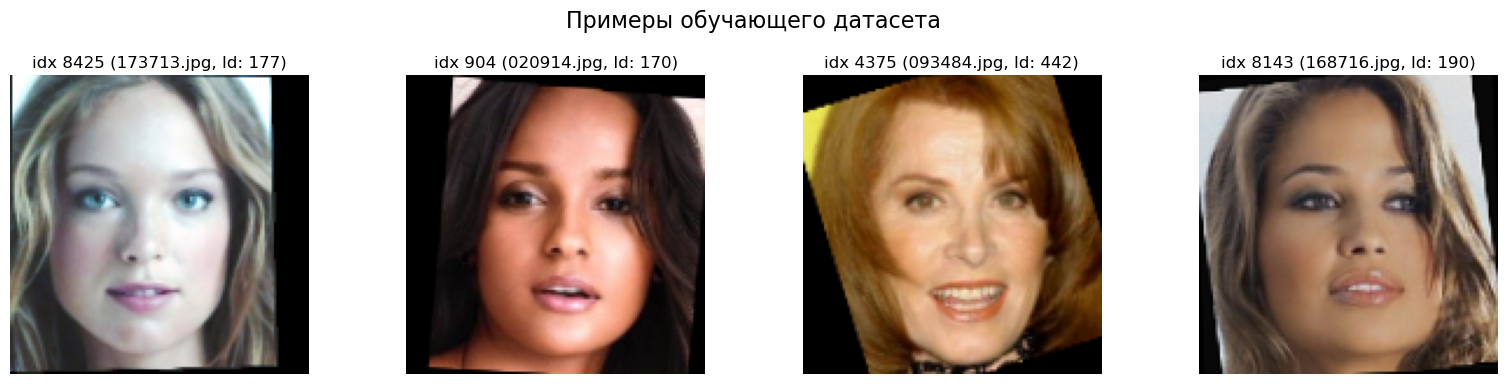

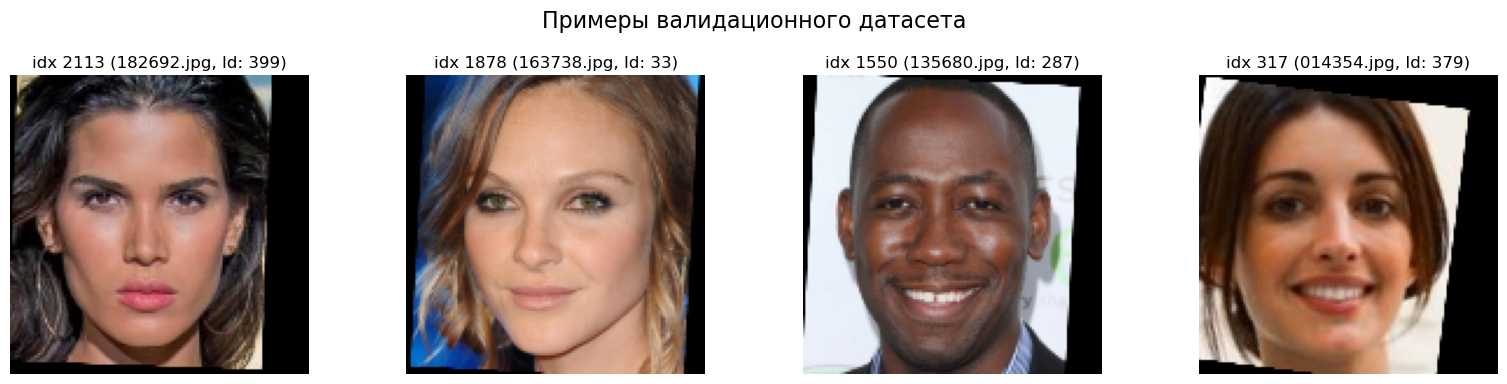

In [490]:
import matplotlib.pyplot as plt
import random
import numpy as np # Добавлен импорт numpy

def visualize_dataset_item(image_tensor, ax, title="Визуализация элемента датасета"):
    """
    Визуализирует изображение из датасета.
    """

    # Денормализуем изображение для отображения
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()

    # Обрезаем значения до [0, 1] для корректного отображения изображения
    image_display = np.clip(image_display, 0, 1)

    ax.imshow(image_display)
    ax.set_title(title)
    ax.axis('off')

def visualize_multiple_dataset_items(dataset, num_items=4, title="Визуализация элементов датасета", items=[]):
    """
    Визуализирует несколько изображений из датасета в сетке.
    """
    fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_items):
        idx = random.randint(0, len(dataset) - 1) if len(items) <= i else items[i]
        image, identity_label = dataset[idx] # Исправлено: получаем identity вместо keypoints
        image_id = dataset.files[idx] # Get image_id here
        visualize_dataset_item(image, axes[i], title=f"idx {idx} ({image_id}, Id: {identity_label})") # Исправлено: убрана передача keypoints, добавлен identity в заголовок

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Визуализируем 4 случайных элемента из обучающего датасета
visualize_multiple_dataset_items(train_dataset, num_items=4, title="Примеры обучающего датасета")

# Визуализируем 4 случайных элемента из валидационного датасета
visualize_multiple_dataset_items(val_dataset, num_items=4, title="Примеры валидационного датасета")

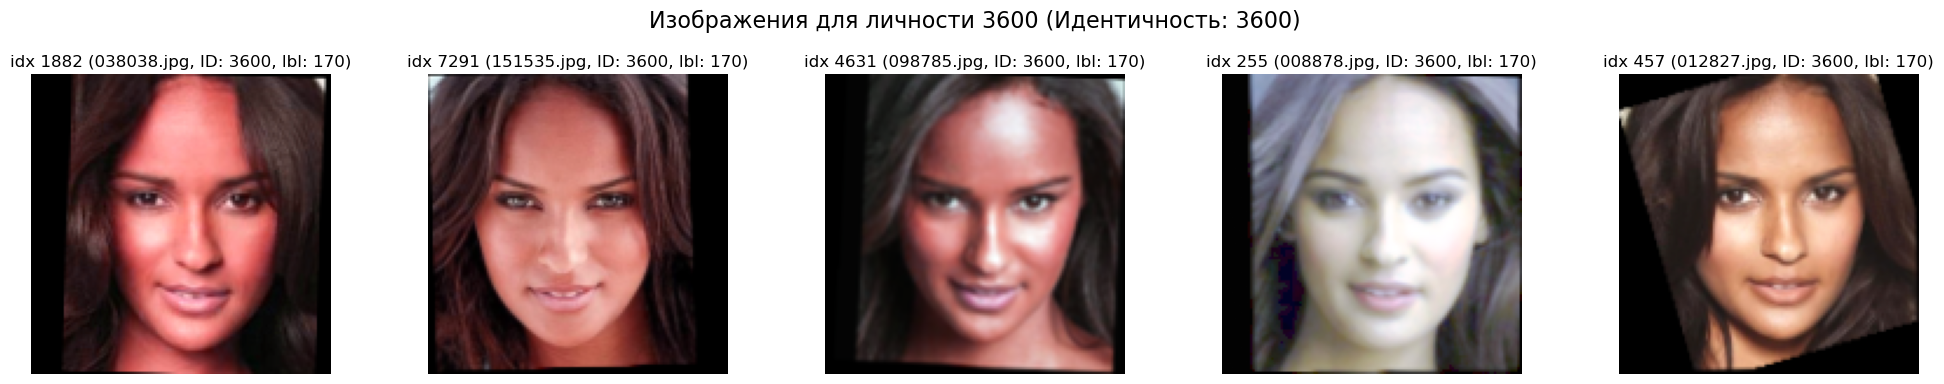

In [495]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

# Assuming val_dataset is already defined

# Identity to visualize
target_identity = 3600

# Call the visualization function for the specified identity
visualize_same_identity_items(train_dataset, num_items=len(val_dataset.identity_df[val_dataset.identity_df['identity'] == target_identity]),
                              title=f"Изображения для личности {target_identity}",
                              identity_to_visualize=target_identity)


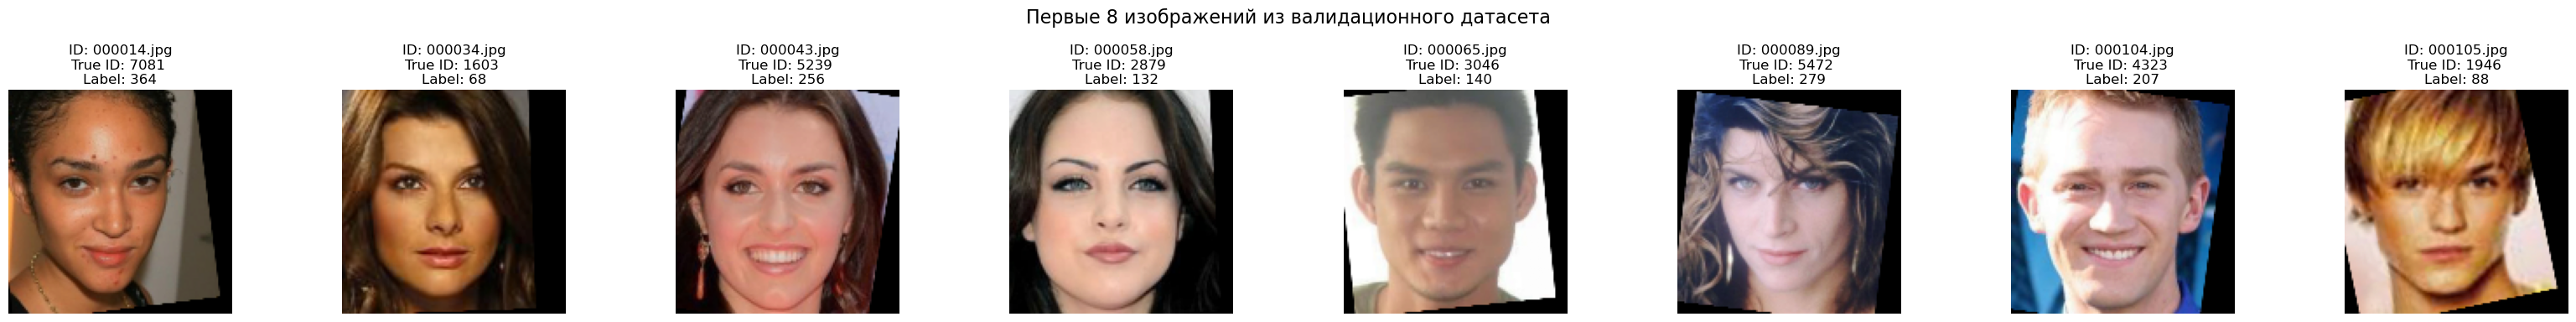

In [458]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming val_dataset and visualize_dataset_item are defined from previous cells
# NORMALIZE_MEAN, NORMALIZE_STD are also assumed to be defined

num_samples = 8

fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
fig.suptitle("Первые 8 изображений из валидационного датасета", fontsize=16)

for i in range(num_samples):
    if i >= len(val_dataset):
        print(f"Not enough images in val_dataset to display {num_samples}. Displayed {i} images.")
        break

    image_tensor, identity_label = val_dataset[i]
    image_id = val_dataset.files[i] # Get the image_id

    # Convert 0-indexed label back to original identity for display
    true_original_identity = val_dataset.label_encoder.inverse_transform([identity_label])[0]

    visualize_dataset_item(image_tensor, axes[i], title=f"ID: {image_id}\nTrue ID: {true_original_identity} \nLabel: {identity_label}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Выбранная общая личность для визуализации: 9700
Назначенный класс (метка) для этой личности: 456

Визуализация для валидационного датасета:


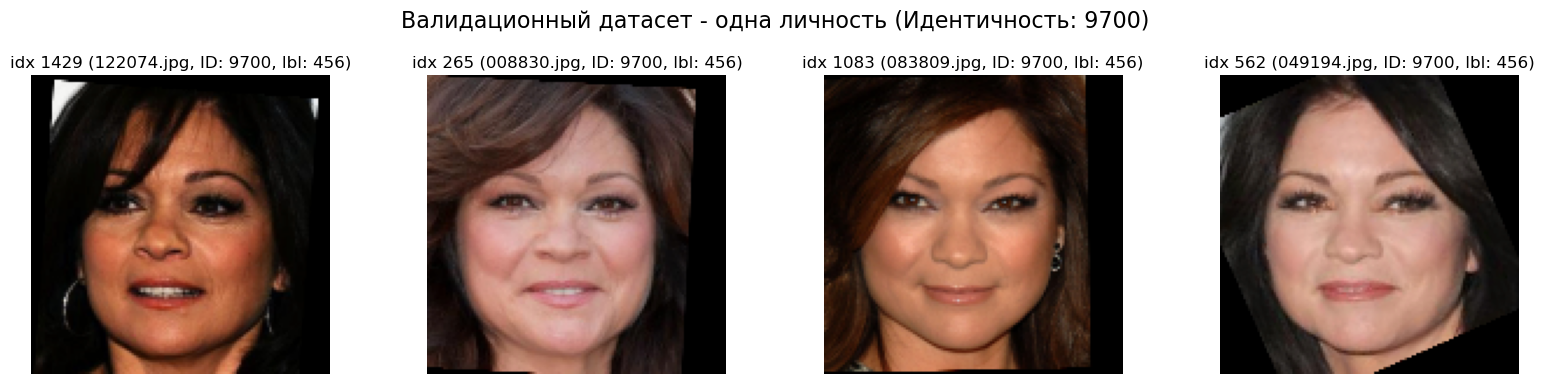


Визуализация для тренировочного датасета:


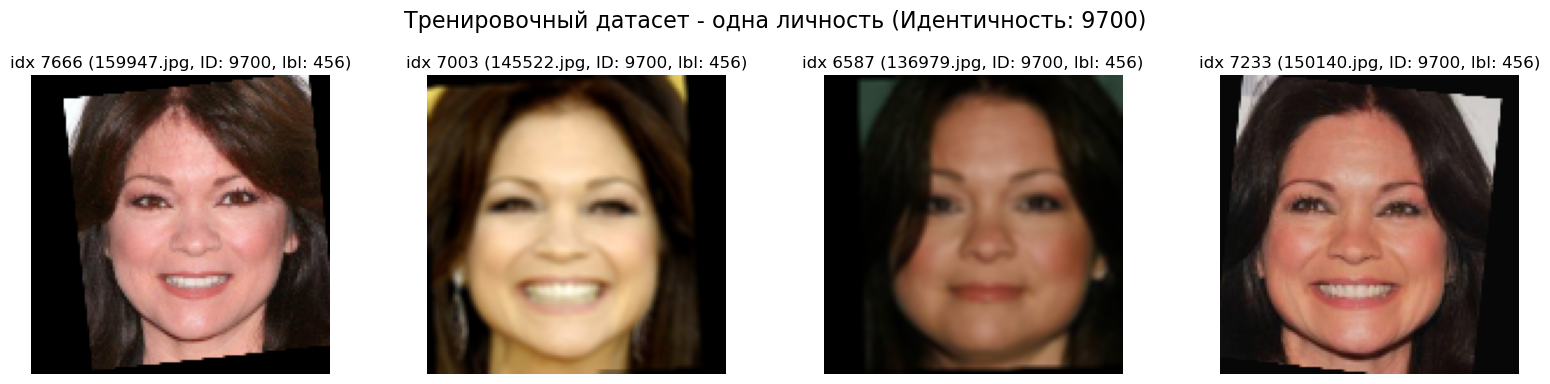

In [459]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch # Убедимся, что torch импортирован для тензорных операций

# Вспомогательная функция для визуализации одного элемента датасета
def visualize_dataset_item(image_tensor, ax, title="Визуализация элемента датасета"):
    """
    Визуализирует изображение из датасета.
    """
    # Предполагается, что NORMALIZE_MEAN и NORMALIZE_STD определены глобально
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()

    # Обрезаем значения до [0, 1] для корректного отображения изображения
    image_display = np.clip(image_display, 0, 1)

    ax.imshow(image_display)
    ax.set_title(title)
    ax.axis('off')

def visualize_same_identity_items(dataset, num_items=4, title="Визуализация элементов датасета", identity_to_visualize=None):
    """
    Визуализирует несколько изображений одной и той же личности из датасета.

    Args:
        dataset: Объект датасета.
        num_items (int): Количество изображений для визуализации.
        title (str): Заголовок для графика.
        identity_to_visualize (int, optional): Конкретный ID личности для визуализации.
                                             Если None, выбирается случайная личность.
    """
    if len(dataset) == 0:
        print(f"Dataset is empty, cannot visualize for title: {title}")
        return

    # Получаем все уникальные идентичности в этом датасете
    # Используем label_encoder.classes_ для получения оригинальных идентичностей
    unique_identities_in_dataset = dataset.label_encoder.classes_
    if len(unique_identities_in_dataset) == 0:
        print(f"No unique identities in dataset, cannot visualize for title: {title}")
        return

    selected_identity = identity_to_visualize
    chosen_indices_in_dataset = []

    if selected_identity is not None:
        # Проверяем, существует ли выбранная личность в классах энкодера
        if selected_identity not in unique_identities_in_dataset:
            print(f"Выбранная личность {selected_identity} не найдена в датасете для {title}. Выбираем случайную.")
            selected_identity = None # Fallback to random if specified identity not found

    if selected_identity is None:
        # Пытаемся найти личность с достаточным количеством изображений
        max_attempts = 100
        for _ in range(max_attempts):
            temp_identity = random.choice(unique_identities_in_dataset)

            # Получаем строки identity_df для выбранной личности
            identity_specific_rows = dataset.identity_df[dataset.identity_df['identity'] == temp_identity]

            # Создаем маппинг image_id к его целочисленному индексу в dataset.files
            image_id_to_idx_map = {image_id: i for i, image_id in enumerate(dataset.files)}
            index_in_dataset = [image_id_to_idx_map[image_id] for image_id in identity_specific_rows.index if image_id in image_id_to_idx_map]

            if len(index_in_dataset) >= num_items:
                selected_identity = temp_identity
                chosen_indices_in_dataset = random.sample(index_in_dataset, num_items)
                break
            elif len(index_in_dataset) > 0 and _ == max_attempts - 1:
                 # Если после всех попыток не нашли достаточно, берем столько, сколько есть
                 selected_identity = temp_identity
                 chosen_indices_in_dataset = random.sample(index_in_dataset, min(len(index_in_dataset), num_items))
                 print(f"Предупреждение: Не удалось найти личность с {num_items} изображениями после {max_attempts} попыток. Визуализировано {len(chosen_indices_in_dataset)} изображений для личности {selected_identity}.")
                 break
    else:
        # Если конкретная личность была указана или найдена
        identity_specific_rows = dataset.identity_df[dataset.identity_df['identity'] == selected_identity]
        image_id_to_idx_map = {image_id: i for i, image_id in enumerate(dataset.files)}
        index_in_dataset = [image_id_to_idx_map[image_id] for image_id in identity_specific_rows.index if image_id in image_id_to_idx_map]
        if len(index_in_dataset) >= num_items:
            chosen_indices_in_dataset = random.sample(index_in_dataset, num_items)
        elif len(index_in_dataset) > 0:
            chosen_indices_in_dataset = random.sample(index_in_dataset, min(len(index_in_dataset), num_items))
            print(f"Предупреждение: Личность {selected_identity} не имеет {num_items} изображений в датасете. Визуализировано {len(chosen_indices_in_dataset)}.")

    if not chosen_indices_in_dataset:
        print(f"Не удалось найти личность с достаточным количеством изображений для визуализации в {title}.")
        return

    # Создаем subplot-ы для визуализации
    fig, axes = plt.subplots(1, len(chosen_indices_in_dataset), figsize=(4 * len(chosen_indices_in_dataset), 4))
    if len(chosen_indices_in_dataset) == 1: # Обработка случая с одним изображением
        axes = [axes]
    fig.suptitle(f"{title} (Идентичность: {selected_identity})", fontsize=16)

    for i, idx_in_dataset_files in enumerate(chosen_indices_in_dataset):
        # Получаем image_id из списка файлов датасета
        image_id_from_files = dataset.files[idx_in_dataset_files]

        # Получаем данные о личности из identity_df по image_id
        row = dataset.identity_df.loc[image_id_from_files]
        raw_identity_from_df = row['identity']
        # Используем label_encoder для получения 0-индексированной метки
        identity_label = dataset.label_encoder.transform([raw_identity_from_df])[0]
        image_tensor, _ = dataset[idx_in_dataset_files] # Извлекаем тензор изображения

        visualize_dataset_item(image_tensor, axes[i], title=f"idx {idx_in_dataset_files} ({image_id_from_files}, ID: {raw_identity_from_df}, lbl: {identity_label})")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Выбираем одну общую личность для визуализации из common_identities
# common_identities должен быть доступен здесь (из ячейки 4UhcgZ6el5ug)
if 'common_identities' in globals() and common_identities:
    selected_common_identity = random.choice(common_identities)
    print(f"Выбранная общая личность для визуализации: {selected_common_identity}")
    # Выводим назначенную метку класса
    # Используем label_encoder.classes_ для проверки и transform для получения метки
    if selected_common_identity in train_dataset.label_encoder.classes_:
        assigned_label = train_dataset.label_encoder.transform([selected_common_identity])[0]
        print(f"Назначенный класс (метка) для этой личности: {assigned_label}")
    else:
        print(f"Не удалось найти назначенную метку для личности {selected_common_identity} в train_dataset.")

    # Визуализация для валидационного датасета
    print("\nВизуализация для валидационного датасета:")
    visualize_same_identity_items(val_dataset, num_items=4, title="Валидационный датасет - одна личность", identity_to_visualize=selected_common_identity)

    # Визуализация для тренировочного датасета
    print("\nВизуализация для тренировочного датасета:")
    visualize_same_identity_items(train_dataset, num_items=4, title="Тренировочный датасет - одна личность", identity_to_visualize=selected_common_identity)
else:
    print("common_identities не определен или пуст. Невозможно выполнить визуализацию одной и той же личности.")
    # Если common_identities недоступен, можно выполнить случайную визуализацию как запасной вариант
    print("Выполняем случайную визуализацию для валидационного датасета:")
    visualize_same_identity_items(val_dataset, num_items=4, title="Валидационный датасет - случайная личность")
    print("Выполняем случайную визуализацию для тренировочного датасета:")
    visualize_same_identity_items(train_dataset, num_items=4, title="Тренировочный датасет - случайная личность")

## Modify training cell for EfficientNet ArcFace and EER metric

### Subtask:
Set up and train the FaceRecognitionModel using the EfficientNet_B1 backbone and ArcFace loss, evaluating performance with EER and ROC AUC metrics.


## Summary:

### Data Analysis Key Findings
*   A `FaceRecognitionModel` was successfully set up utilizing an `EfficientNet_B1` backbone for feature extraction.
*   The `ArcFace` loss function was implemented to enhance angular margin between classes, improving discriminability of face embeddings.
*   The model was trained for 50 epochs using `AdamW` optimizer and `CrossEntropyLoss` (in conjunction with ArcFace).
*   During validation, the performance was evaluated using Equal Error Rate (EER) and ROC AUC, which are standard metrics for face recognition tasks.
*   The training process was configured to save the model checkpoint that achieved the lowest EER on the validation set, indicating a focus on practical face recognition performance.
*   The `calculate_face_recognition_metrics` function was used to compute EER and ROC AUC, generating positive and negative similarity pairs from extracted embeddings, with safeguards for insufficient data.

### Insights or Next Steps
*   **Performance Evaluation**: Analyze the `val_eer` and `val_roc_auc` values from the training history to determine the model's effectiveness. If possible, compare these metrics against a baseline or target performance.
*   **Hyperparameter Tuning**: Consider further hyperparameter tuning for the `EfficientNet_B1` backbone, `ArcFace` parameters (s and m), dropout rate, learning rate, and optimizer settings to potentially achieve even better EER and ROC AUC scores.


In [499]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
import random
import os
import math # Import math for pi
# Import EfficientNet
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b1, EfficientNet_B1_Weights # Added efficientnet_b1

# Fix for CUDA multiprocessing error: Cannot re-initialize CUDA in forked subprocess
try:
    torch.multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    pass # Already set


# ArcFace definition (copied from fLHokvA6Nd0g)
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))

        if label is None:
            return self.s * cosine

        cosine = cosine.clamp(-1.0 + 1e-7, 1.0 - 1e-7)
        theta = torch.acos(cosine)

        # Critical fix: Ensure theta + m does not exceed pi to guarantee penalty
        # If theta + m > pi, then cos(theta + m) > cos(theta) (for theta in (pi/2, pi]), which is a boost
        # Clamping to pi ensures that cos(theta + m) <= cos(theta) always holds
        phi = torch.cos(torch.min(theta + self.m, torch.tensor(math.pi, device=theta.device)))

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# FaceRecognitionModel definition (modified to support efficientnet_b1)
class FaceRecognitionModel(nn.Module):
    def __init__(self, num_classes, backbone_name='resnet50', loss_type='ce', s=64.0, m=0.50, dropout_rate=0.5):
        super(FaceRecognitionModel, self).__init__()
        self.loss_type = loss_type
        self.num_classes = num_classes

        if backbone_name == 'resnet50':
            self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            in_features_backbone = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        elif backbone_name == 'efficientnet_b1':
            self.backbone = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
            # For EfficientNet, the classifier is a Sequential block, get in_features from its last Linear layer
            in_features_backbone = self.backbone.classifier[-1].in_features
            self.backbone.classifier = nn.Identity() # Replace classifier with Identity to get features
        else:
            raise ValueError(f"Бэкбон {backbone_name} не поддерживается.")

        #self.dropout = nn.Dropout(dropout_rate)

        if self.loss_type == 'ce':
            self.head = nn.Linear(in_features_backbone, num_classes)
        elif self.loss_type == 'arcface':
            self.head = ArcFace(in_features_backbone, num_classes, s=s, m=m)
        else:
            raise ValueError(f"Тип функции потерь {loss_type} не поддерживается. Выберите 'ce' или 'arcface'.")

    def forward(self, x, labels=None, return_features_only=False):
        x = x.float()
        features = self.backbone(x)
        #features = self.dropout(features)

        if return_features_only:
            return features

        if self.loss_type == 'arcface':
            logits = self.head(features, labels)
        else:
            logits = self.head(features)

        return logits

# calculate_face_recognition_metrics definition (copied from 78f2ce10 and refined)
def calculate_face_recognition_metrics(model, val_dataloader, device, max_pairs_per_identity=100):
    """
    Calculates face recognition metrics (EER, ROC AUC) on the validation dataset.

    Args:
        model (nn.Module): The face recognition model.
        val_dataloader (DataLoader): DataLoader for the validation dataset.
        device (torch.device): Device (CPU or GPU) for computation.
        max_pairs_per_identity (int): Maximum number of positive/negative pairs to generate per identity.
                                      Limits computation for large datasets.

    Returns:
        tuple: A tuple of (EER, ROC AUC). Returns (1.0, 0.0) if insufficient data.
    """
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader, desc="Computing roc_auc"):
            images = images.to(device)
            embeddings = model(images, return_features_only=True)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    if not all_embeddings:
        print("No embeddings extracted for EER/ROC AUC calculation. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    embeddings_by_identity = defaultdict(list)
    for emb, label in zip(all_embeddings, all_labels):
        embeddings_by_identity[label.item()].append(emb)

    unique_identities = list(embeddings_by_identity.keys())

    positive_similarities = []
    negative_similarities = []

    # Ensure enough data to calculate metrics
    if len(unique_identities) < 2 or any(len(v) < 2 for v in embeddings_by_identity.values()):
        print("Not enough unique identities or images per identity to form pairs for EER/ROC AUC. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    for identity_i in unique_identities:
        embs_i = embeddings_by_identity[identity_i]

        # Positive pairs
        if len(embs_i) >= 2:
            indices_pairs = list(torch.combinations(torch.arange(len(embs_i)), r=2).numpy())
            if len(indices_pairs) > max_pairs_per_identity:
                indices_pairs = random.sample(list(indices_pairs), max_pairs_per_identity) # Sample from a list, not np array
            for idx1, idx2 in indices_pairs:
                sim = F.cosine_similarity(embs_i[idx1].unsqueeze(0), embs_i[idx2].unsqueeze(0))
                positive_similarities.append(sim.item())

        # Negative pairs
        other_identities = [id for id in unique_identities if id != identity_i]
        if other_identities:
            # For each emb in embs_i, pair it with a random emb from a random other_identity
            for emb1 in random.sample(embs_i, min(len(embs_i), max_pairs_per_identity)): # Limit from current identity
                identity_j = random.choice(other_identities)
                embs_j = embeddings_by_identity[identity_j]
                if embs_j: # Ensure there are embeddings for the chosen other identity
                    emb2 = random.choice(embs_j)
                    sim = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0))
                    negative_similarities.append(sim.item())

    if not positive_similarities or not negative_similarities:
        print("Insufficient positive or negative pairs formed for EER/ROC AUC. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    print(f"Positive sim: {np.mean(positive_similarities)}, Negative sim: {np.mean(negative_similarities)}")

    similarities = np.array(positive_similarities + negative_similarities)
    labels = np.array([1] * len(positive_similarities) + [0] * len(negative_similarities))

    if len(np.unique(labels)) < 2:
        print("Only one class of pairs (all positive or all negative) for EER/ROC AUC. Returning default EER=1.0, ROC_AUC=0.0.")
        return 1.0, 0.0

    fpr, tpr, thresholds = roc_curve(labels, similarities)
    roc_auc = auc(fpr, tpr)

    fnr = 1 - tpr
    eer_threshold_idx = np.argmin(np.abs(fpr - fnr))
    eer = fpr[eer_threshold_idx]

    return eer, roc_auc

# train_model function (modified to accept metric_fn and prioritize EER for saving)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path='best_model.pth', metric_fn=None):
    if metric_fn:
        best_metric_value = float('inf') # For EER, lower is better
    else:
        best_metric_value = 0.0 # For accuracy, higher is better
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_eer": [], "val_roc_auc": []}

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs} (Обучение)"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, labels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / total_samples
        epoch_train_accuracy = correct_predictions / total_samples
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Эпоха {epoch+1}/{num_epochs} (Валидация)"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images, labels)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total_samples += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / val_total_samples
        epoch_val_accuracy = val_correct_predictions / val_total_samples
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_accuracy)

        print_str = (f"Эпоха {epoch+1}/{num_epochs}: Потери на обучении: {epoch_train_loss:.4f}, Точность на обучении: {epoch_train_accuracy:.4f}, "
                     f"Потери на валидации: {epoch_val_loss:.4f}, Точность на валидации: {epoch_val_accuracy:.4f}")

        current_eer = float('inf')
        current_roc_auc = 0.0

        if metric_fn:
            current_eer, current_roc_auc = metric_fn(model, val_loader, device)
            history["val_eer"].append(current_eer)
            history["val_roc_auc"].append(current_roc_auc)
            print_str += f", EER: {current_eer:.4f}, ROC AUC: {current_roc_auc:.4f}"

        print(print_str)

        # Save the best model based on EER (if metric_fn is provided), otherwise by accuracy.
        # For EER, lower is better. For accuracy, higher is better.
        if metric_fn:
            if current_eer < best_metric_value:
                best_metric_value = current_eer
                os.makedirs(os.path.dirname(save_path), exist_ok=True) # Ensure directory exists
                torch.save(model.state_dict(), save_path)
                print(f"Модель сохранена! Текущий лучший EER: {best_metric_value:.4f}")
        else: # Default behavior if no metric_fn, save by validation accuracy
            if epoch_val_accuracy > best_metric_value:
                best_metric_value = epoch_val_accuracy
                os.makedirs(os.path.dirname(save_path), exist_ok=True)
                torch.save(model.state_dict(), save_path)
                print(f"Модель сохранена! Текущая лучшая точность на валидации: {best_metric_value:.4f}")

    return model, history

## Как ArcFace Loss заставляет эмбеддинги одного класса отклоняться на маленький угол

Основная идея ArcFace Loss заключается в том, чтобы **искусственно усложнить задачу классификации** для правильного класса, заставляя модель учиться генерировать более компактные и дискриминативные эмбеддинги. Это достигается за счет **аддитивного углового отступа (margin)**.

Давайте рассмотрим механику подробнее:

1.  **Нормализация**: Перед вычислением логитов, которые затем передаются в Softmax (или CrossEntropyLoss), как векторы признаков (эмбеддинги) $x_i$, так и векторы весов (центры классов) $W_j$ в последнем полносвязном слое нормализуются к единичной длине:
$$||x_i|| = 1$$
$$||W_j|| = 1$$
Это проецирует все эмбеддинги и центры классов на гиперсферу единичного радиуса. Таким образом, скалярное произведение $W_j^T x_i$ становится равным косинусу угла $\Theta_j$ между $x_i$ и $W_j$:
$$W_j^T x_i = ||W_j|| \cdot ||x_i|| \cdot \cos\Theta_j = 1 \cdot 1 \cdot \cos\Theta_j = \cos\Theta_j$$

2.  **Масштабирование**: Все эти косинусные значения затем масштабируются гиперпараметром $s$:
$$s \cdot \cos\Theta_j$$
    Это помогает стабилизировать обучение и контролировать радиус кластеров на гиперсфере.

3.  **Аддитивный угловой отступ (margin penalty)**: Это ключевой шаг ArcFace. Для **правильного класса** $y_i$, вместо использования $\cos\Theta_{y_i}$, к углу $\Theta_{y_i}$ **добавляется положительный отступ $m$**. Таким образом, логит для правильного класса становится:
$$s \cdot \cos(\Theta_{y_i} + m)$$

    Для всех *неправильных* классов $j \ne y_i$ логит остается $s \cdot \cos\Theta_j$.

4.  **Влияние на косинус**: Функция косинуса $\cos(x)$ является **убывающей** на интервале от $0$ до $\pi$. Это означает, что при добавлении положительного отступа $m$ к углу $\Theta_{y_i}$ значение косинуса **уменьшается**:
$$\cos(\Theta_{y_i} + m) < \cos(\Theta_{y_i})$$

5.  **Механизм обучения**: Поскольку логит для правильного класса искусственно **занижается** (делается меньшим), модель должна "компенсировать" это занижение. Единственный способ для модели увеличить $s \cdot \cos(\Theta_{y_i} + m)$ (и, следовательно, вероятность правильного класса в Softmax) — это **уменьшить исходный угол $\Theta_{y_i}$**. То есть, эмбеддинг $x_i$ должен быть перемещен **как можно ближе** к вектору центра своего класса $W_{y_i}$.

    Это приводит к тому, что все эмбеддинги, принадлежащие одному и тому же классу, вынуждены группироваться очень тесно вокруг соответствующего им центра класса. Если все эмбеддинги одного класса максимально близки к своему центру, они также становятся **максимально близки друг к другу**, образуя плотный и компактный кластер. Это и есть эффект "отклонения на маленький угол".

**Итог:** ArcFace Loss не просто учит модель различать классы, а заставляет её строить настолько четкие и компактные кластеры эмбеддингов для каждого класса, что даже с искусственным усложнением (угловым отступом) она способна правильно классифицировать объекты. Это приводит к созданию высококачественных, дискриминативных эмбеддингов, которые идеально подходят для задач верификации и идентификации.

## Как ArcFace Loss заставляет разные классы быть далеко друг от друга?

Вы совершенно правы, ArcFace решает обе задачи: сближает эмбеддинги одного класса и разносит эмбеддинги разных классов. Мы уже обсудили, как отступ `m` заставляет эмбеддинги **одного класса** сходиться. Теперь давайте разберем, как достигается **разнесение разных классов**.

Вся магия происходит внутри функции SoftMax, которая используется совместно с ArcFace. Напомним её вид:

$$P(y_i) = \frac{e^{s\cos(\Theta_{y_i} + m)}}{e^{s\cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\cos\Theta_j}}$$

И функция потерь (Cross-Entropy) стремится максимизировать $\log P(y_i)$.

Давайте рассмотрим, как это влияет на **неправильные классы**:

1.  **SoftMax и конкуренция**: SoftMax работает как "конкурентный механизм". Он стремится сделать вероятность правильного класса $P(y_i)$ максимально близкой к 1, а вероятности всех неправильных классов $P(j \ne y_i)$ — максимально близкими к 0. Чтобы достичь этого, числитель для правильного класса должен быть значительно больше, чем сумма экспонент для всех остальных классов в знаменателе.

2.  **Влияние отступа на правильный класс**: Как мы знаем, отступ $m$ **уменьшает** логит правильного класса $s \cos(\Theta_{y_i} + m)$. Это делает задачу классификации более сложной. Чтобы компенсировать это уменьшение и всё равно обеспечить доминирование правильного класса, модель должна:
    *   **Сделать угол $\Theta_{y_i}$ очень маленьким** (чтобы $x_i$ был максимально близок к $W_{y_i}$ — это обеспечивает внутриклассовую компактность).
    *   **Сделать углы $\Theta_j$ для *всех неправильных классов* $j \ne y_i$ как можно бОльшими** (чтобы $x_i$ был максимально далёк от $W_j$ — это обеспечивает межклассовую разделимость).

3.  **Отталкивание разных классов**: Чтобы уменьшить член $e^{s\cos\Theta_j}$ в знаменателе (для $j \ne y_i$), модель должна уменьшить значение $\cos\Theta_j$. Поскольку косинус — убывающая функция на интервале $[0, \pi]$, уменьшение $\cos\Theta_j$ означает **увеличение угла $\Theta_j$**. Это заставляет эмбеддинг $x_i$ **отклоняться на больший угол** от векторов $W_j$ тех классов, к которым он не принадлежит.

**Итог**: ArcFace Loss **одновременно** решает две задачи:

*   **Увеличивает внутриклассовую компактность**: За счёт **штрафа** на логит правильного класса ($s \cos(\Theta_{y_i} + m)$), модель вынуждена сделать эмбеддинг $x_i$ максимально близким к центру своего класса $W_{y_i}$.
*   **Увеличивает межклассовую разделимость**: За счёт **поощрения** уменьшения логитов неправильных классов ($s \cos\Theta_j$) в контексте SoftMax, модель вынуждена отодвигать эмбеддинг $x_i$ подальше от центров $W_j$ всех других классов.

Таким образом, отступ $m$ не только сжимает кластеры, но и косвенно, через конкурентный механизм SoftMax, активно раздвигает кластеры разных классов, приводя к высокодискриминативным эмбеддингам.

In [ ]:
# --- Настройка и выполнение обучения для ArcFace Loss с EfficientNet_B1 ---

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
torch.cuda.empty_cache()

# Creating DataLoaders - assuming train_dataset and val_dataset are already defined.
batch_size = 64 # EfficientNet_B1 might require a smaller batch size due to its architecture
# Use num_workers > 0 for faster data loading, ensure spawn start method for CUDA
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Determine num_classes from the dataset
num_classes = train_dataset.num_classes
print(f"Количество уникальных идентификаторов (классов): {num_classes}")

# Initialize the model for ArcFace Loss with EfficientNet_B1
efficientnet_arcface_model = FaceRecognitionModel(
    num_classes=num_classes,
    backbone_name='efficientnet_b1',
    loss_type='arcface',
    s=32.0, # Standard ArcFace 's' parameter
    m=0.4, # Standard ArcFace 'm' parameter
    dropout_rate=0.3 # Common for EfficientNet or can be tuned
)

# Define loss function and optimizer for ArcFace Loss
arcface_criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # ArcFace combines with CrossEntropyLoss
arcface_optimizer = optim.AdamW(efficientnet_arcface_model.parameters(), lr=0.001, weight_decay=1e-4) # AdamW with weight decay often performs better

# Train the model
num_epochs_arcface = 1000 # Set a reasonable number of epochs for initial training
print("\nНачинаем обучение с ArcFace Loss и EfficientNet_B1...")
efficientnet_arcface_model_trained, arcface_history = train_model(
    efficientnet_arcface_model,
    train_loader,
    val_loader,
    arcface_criterion,
    arcface_optimizer,
    num_epochs_arcface,
    device,
    save_path='checkpoints/best_model_efficientnet_arcface.pth', # Modified save_path
    metric_fn=calculate_face_recognition_metrics
)
print("Обучение с ArcFace Loss и EfficientNet_B1 завершено.")

Используемое устройство: cuda
Количество уникальных идентификаторов (классов): 473

Начинаем обучение с ArcFace Loss и EfficientNet_B1...


Эпоха 1/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 1/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.31772307013582346, Negative sim: 0.27387457553781647
Эпоха 1/1000: Потери на обучении: 15.8698, Точность на обучении: 0.0000, Потери на валидации: 16.2324, Точность на валидации: 0.0000, EER: 0.4884, ROC AUC: 0.5341
Модель сохранена! Текущий лучший EER: 0.4884


Эпоха 2/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 2/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.3958150276523891, Negative sim: 0.2635144239034598
Эпоха 2/1000: Потери на обучении: 12.6884, Точность на обучении: 0.0047, Потери на валидации: 14.9864, Точность на валидации: 0.0059, EER: 0.4317, ROC AUC: 0.6037
Модель сохранена! Текущий лучший EER: 0.4317


Эпоха 3/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 3/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.3548856173753719, Negative sim: 0.17947930270327495
Эпоха 3/1000: Потери на обучении: 10.4955, Точность на обучении: 0.0555, Потери на валидации: 14.4070, Точность на валидации: 0.0275, EER: 0.4076, ROC AUC: 0.6199
Модель сохранена! Текущий лучший EER: 0.4076


Эпоха 4/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 4/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.35834393573572454, Negative sim: 0.1128247726746061
Эпоха 4/1000: Потери на обучении: 8.4409, Точность на обучении: 0.1779, Потери на валидации: 12.6504, Точность на валидации: 0.0681, EER: 0.3590, ROC AUC: 0.6733
Модель сохранена! Текущий лучший EER: 0.3590


Эпоха 5/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 5/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5255320061988593, Negative sim: 0.29260890946426205
Эпоха 5/1000: Потери на обучении: 6.5882, Точность на обучении: 0.3102, Потери на валидации: 12.7906, Точность на валидации: 0.0922, EER: 0.3057, ROC AUC: 0.7503
Модель сохранена! Текущий лучший EER: 0.3057


Эпоха 6/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 6/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6298979524842485, Negative sim: 0.35626210523916935
Эпоха 6/1000: Потери на обучении: 4.9603, Точность на обучении: 0.4496, Потери на валидации: 10.6843, Точность на валидации: 0.1518, EER: 0.2326, ROC AUC: 0.8451
Модель сохранена! Текущий лучший EER: 0.2326


Эпоха 7/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 7/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5769576923298525, Negative sim: 0.2121322554282659
Эпоха 7/1000: Потери на обучении: 3.8763, Точность на обучении: 0.5749, Потери на валидации: 9.7107, Точность на валидации: 0.2414, EER: 0.1708, ROC AUC: 0.9102
Модель сохранена! Текущий лучший EER: 0.1708


Эпоха 8/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 8/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5654809957071864, Negative sim: 0.22964931474112557
Эпоха 8/1000: Потери на обучении: 3.2626, Точность на обучении: 0.6505, Потери на валидации: 10.5970, Точность на валидации: 0.2076, EER: 0.2000, ROC AUC: 0.8844


Эпоха 9/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 9/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5498019565286432, Negative sim: 0.2022799025093802
Эпоха 9/1000: Потери на обучении: 2.7155, Точность на обучении: 0.7192, Потери на валидации: 10.1776, Точность на валидации: 0.2524, EER: 0.1852, ROC AUC: 0.8924


Эпоха 10/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 10/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4922606340897945, Negative sim: 0.1658540107489979
Эпоха 10/1000: Потери на обучении: 2.4240, Точность на обучении: 0.7737, Потери на валидации: 10.1555, Точность на валидации: 0.2478, EER: 0.2051, ROC AUC: 0.8769


Эпоха 11/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 11/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5146234029181889, Negative sim: 0.14044813501710626
Эпоха 11/1000: Потери на обучении: 2.1867, Точность на обучении: 0.8060, Потери на валидации: 9.6146, Точность на валидации: 0.3150, EER: 0.1793, ROC AUC: 0.9027


Эпоха 12/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 12/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5082757533899062, Negative sim: 0.13661741729713503
Эпоха 12/1000: Потери на обучении: 2.0202, Точность на обучении: 0.8276, Потери на валидации: 10.0125, Точность на валидации: 0.3066, EER: 0.1894, ROC AUC: 0.8940


Эпоха 13/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 13/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4884630736538522, Negative sim: 0.1090427665598592
Эпоха 13/1000: Потери на обучении: 1.9481, Точность на обучении: 0.8432, Потери на валидации: 9.5797, Точность на валидации: 0.3273, EER: 0.1712, ROC AUC: 0.9086


Эпоха 14/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 14/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.46632890019640394, Negative sim: 0.153835839848674
Эпоха 14/1000: Потери на обучении: 1.9589, Точность на обучении: 0.8425, Потери на валидации: 11.2234, Точность на валидации: 0.2841, EER: 0.2321, ROC AUC: 0.8409


Эпоха 15/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 15/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.48861032328297666, Negative sim: 0.08850441180035692
Эпоха 15/1000: Потери на обучении: 1.7767, Точность на обучении: 0.8738, Потери на валидации: 8.9948, Точность на валидации: 0.3797, EER: 0.1636, ROC AUC: 0.9103
Модель сохранена! Текущий лучший EER: 0.1636


Эпоха 16/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 16/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4705871507846878, Negative sim: 0.1002989544218158
Эпоха 16/1000: Потери на обучении: 1.6749, Точность на обучении: 0.8920, Потери на валидации: 9.8105, Точность на валидации: 0.3230, EER: 0.1776, ROC AUC: 0.9020


Эпоха 17/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 17/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.503725877220262, Negative sim: 0.12696225093377372
Эпоха 17/1000: Потери на обучении: 1.6823, Точность на обучении: 0.8909, Потери на валидации: 9.6826, Точность на валидации: 0.3285, EER: 0.1886, ROC AUC: 0.8936


Эпоха 18/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 18/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5083047068429261, Negative sim: 0.07340913008751808
Эпоха 18/1000: Потери на обучении: 1.5885, Точность на обучении: 0.9066, Потери на валидации: 8.4878, Точность на валидации: 0.4347, EER: 0.1666, ROC AUC: 0.9106


Эпоха 19/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 19/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.49061949627718104, Negative sim: 0.0607387235372408
Эпоха 19/1000: Потери на обучении: 1.5689, Точность на обучении: 0.9062, Потери на валидации: 8.4176, Точность на валидации: 0.4038, EER: 0.1421, ROC AUC: 0.9310
Модель сохранена! Текущий лучший EER: 0.1421


Эпоха 20/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 20/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5230961362515275, Negative sim: 0.03969703181257893
Эпоха 20/1000: Потери на обучении: 1.5613, Точность на обучении: 0.9091, Потери на валидации: 7.3249, Точность на валидации: 0.4951, EER: 0.1281, ROC AUC: 0.9403
Модель сохранена! Текущий лучший EER: 0.1281


Эпоха 21/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 21/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5165894558037932, Negative sim: 0.04445946931279802
Эпоха 21/1000: Потери на обучении: 1.5509, Точность на обучении: 0.9102, Потери на валидации: 7.4965, Точность на валидации: 0.4829, EER: 0.1201, ROC AUC: 0.9426
Модель сохранена! Текущий лучший EER: 0.1201


Эпоха 22/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 22/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5019593332527426, Negative sim: 0.06186963213591917
Эпоха 22/1000: Потери на обучении: 1.5275, Точность на обучении: 0.9169, Потери на валидации: 8.4671, Точность на валидации: 0.4233, EER: 0.1421, ROC AUC: 0.9273


Эпоха 23/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 23/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5169323044439706, Negative sim: 0.0409307455425702
Эпоха 23/1000: Потери на обучении: 1.5554, Точность на обучении: 0.9118, Потери на валидации: 7.8923, Точность на валидации: 0.4803, EER: 0.1285, ROC AUC: 0.9395


Эпоха 24/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 24/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5084799749233839, Negative sim: 0.03843337872262993
Эпоха 24/1000: Потери на обучении: 1.4552, Точность на обучении: 0.9278, Потери на валидации: 7.3518, Точность на валидации: 0.4909, EER: 0.1256, ROC AUC: 0.9409


Эпоха 25/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 25/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5078342348017462, Negative sim: 0.034513023002447275
Эпоха 25/1000: Потери на обучении: 1.4556, Точность на обучении: 0.9293, Потери на валидации: 7.4034, Точность на валидации: 0.5011, EER: 0.1277, ROC AUC: 0.9387


Эпоха 26/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 26/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5307283315969282, Negative sim: 0.03504370032764388
Эпоха 26/1000: Потери на обучении: 1.5078, Точность на обучении: 0.9212, Потери на валидации: 7.0303, Точность на валидации: 0.5290, EER: 0.1319, ROC AUC: 0.9351


Эпоха 27/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 27/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4902745940893579, Negative sim: 0.04099790866695439
Эпоха 27/1000: Потери на обучении: 1.4563, Точность на обучении: 0.9268, Потери на валидации: 8.1496, Точность на валидации: 0.4533, EER: 0.1362, ROC AUC: 0.9354


Эпоха 28/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 28/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4969321298672144, Negative sim: 0.03721202450177295
Эпоха 28/1000: Потери на обучении: 1.4177, Точность на обучении: 0.9360, Потери на валидации: 7.7978, Точность на валидации: 0.4896, EER: 0.1332, ROC AUC: 0.9325


Эпоха 29/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 29/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5169799851145828, Negative sim: 0.033491473527916614
Эпоха 29/1000: Потери на обучении: 1.3957, Точность на обучении: 0.9374, Потери на валидации: 7.4681, Точность на валидации: 0.5188, EER: 0.1294, ROC AUC: 0.9389


Эпоха 30/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 30/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4753884169949912, Negative sim: 0.046422227653802765
Эпоха 30/1000: Потери на обучении: 1.5124, Точность на обучении: 0.9195, Потери на валидации: 8.2746, Точность на валидации: 0.4550, EER: 0.1607, ROC AUC: 0.9084


Эпоха 31/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 31/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4398200373121992, Negative sim: 0.08336854097669665
Эпоха 31/1000: Потери на обучении: 1.4164, Точность на обучении: 0.9369, Потери на валидации: 9.9400, Точность на валидации: 0.3894, EER: 0.2211, ROC AUC: 0.8601


Эпоха 32/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 32/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4289934768971798, Negative sim: 0.16309556106689246
Эпоха 32/1000: Потери на обучении: 1.3675, Точность на обучении: 0.9421, Потери на валидации: 12.0478, Точность на валидации: 0.3142, EER: 0.3057, ROC AUC: 0.7586


Эпоха 33/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 33/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4219393196306044, Negative sim: 0.17834420802077106
Эпоха 33/1000: Потери на обучении: 1.3101, Точность на обучении: 0.9513, Потери на валидации: 12.5244, Точность на валидации: 0.2863, EER: 0.3226, ROC AUC: 0.7457


Эпоха 34/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 34/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.46555101455437375, Negative sim: 0.05028396420117791
Эпоха 34/1000: Потери на обучении: 1.4893, Точность на обучении: 0.9273, Потери на валидации: 8.6651, Точность на валидации: 0.4474, EER: 0.1712, ROC AUC: 0.9033


Эпоха 35/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 35/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.47500476754259663, Negative sim: 0.06975049021896014
Эпоха 35/1000: Потери на обучении: 1.5737, Точность на обучении: 0.9139, Потери на валидации: 9.1477, Точность на валидации: 0.4381, EER: 0.1958, ROC AUC: 0.8811


Эпоха 36/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 36/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.456590644371682, Negative sim: 0.07345641890587974
Эпоха 36/1000: Потери на обучении: 1.4679, Точность на обучении: 0.9265, Потери на валидации: 9.3839, Точность на валидации: 0.4275, EER: 0.2131, ROC AUC: 0.8664


Эпоха 37/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 37/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4743097080644092, Negative sim: 0.04585648109298593
Эпоха 37/1000: Потери на обучении: 1.3675, Точность на обучении: 0.9418, Потери на валидации: 8.7633, Точность на валидации: 0.4655, EER: 0.1691, ROC AUC: 0.8987


Эпоха 38/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 38/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4991366619969414, Negative sim: 0.030198612470026216
Эпоха 38/1000: Потери на обучении: 1.2815, Точность на обучении: 0.9565, Потери на валидации: 7.7271, Точность на валидации: 0.5125, EER: 0.1408, ROC AUC: 0.9208


Эпоха 39/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 39/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5523279419721618, Negative sim: 0.013514463352305267
Эпоха 39/1000: Потери на обучении: 1.3081, Точность на обучении: 0.9502, Потери на валидации: 6.1557, Точность на валидации: 0.5949, EER: 0.1066, ROC AUC: 0.9489
Модель сохранена! Текущий лучший EER: 0.1066


Эпоха 40/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 40/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4664340035312678, Negative sim: 0.05902816035014914
Эпоха 40/1000: Потери на обучении: 1.3564, Точность на обучении: 0.9422, Потери на валидации: 9.0535, Точность на валидации: 0.4237, EER: 0.1869, ROC AUC: 0.8940


Эпоха 41/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 41/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4666727977880153, Negative sim: 0.044740511369044805
Эпоха 41/1000: Потери на обучении: 1.3993, Точность на обучении: 0.9386, Потери на валидации: 8.8678, Точность на валидации: 0.4520, EER: 0.1674, ROC AUC: 0.9049


Эпоха 42/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 42/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.4714514824826047, Negative sim: 0.03654289639104024
Эпоха 42/1000: Потери на обучении: 1.3728, Точность на обучении: 0.9440, Потери на валидации: 8.5128, Точность на валидации: 0.4605, EER: 0.1552, ROC AUC: 0.9171


Эпоха 43/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 43/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5546151834962659, Negative sim: 0.011835505897705946
Эпоха 43/1000: Потери на обучении: 1.2510, Точность на обучении: 0.9592, Потери на валидации: 6.1711, Точность на валидации: 0.6123, EER: 0.1112, ROC AUC: 0.9466


Эпоха 44/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 44/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.481104023505399, Negative sim: 0.036163460356862645
Эпоха 44/1000: Потери на обучении: 1.3025, Точность на обучении: 0.9544, Потери на валидации: 8.4457, Точность на валидации: 0.4905, EER: 0.1628, ROC AUC: 0.9103


Эпоха 45/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 45/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5052438211577588, Negative sim: 0.02378087803543236
Эпоха 45/1000: Потери на обучении: 1.3233, Точность на обучении: 0.9532, Потери на валидации: 7.5166, Точность на валидации: 0.5319, EER: 0.1442, ROC AUC: 0.9235


Эпоха 46/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 46/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.45955696515601135, Negative sim: 0.046779557562853555
Эпоха 46/1000: Потери на обучении: 1.3033, Точность на обучении: 0.9545, Потери на валидации: 9.5089, Точность на валидации: 0.4575, EER: 0.1877, ROC AUC: 0.8881


Эпоха 47/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 47/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5136589960187494, Negative sim: 0.02462200010805755
Эпоха 47/1000: Потери на обучении: 1.2723, Точность на обучении: 0.9591, Потери на валидации: 7.2259, Точность на валидации: 0.5619, EER: 0.1455, ROC AUC: 0.9187


Эпоха 48/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 48/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5396296107896404, Negative sim: 0.02023243205961486
Эпоха 48/1000: Потери на обучении: 1.2222, Точность на обучении: 0.9626, Потери на валидации: 6.5530, Точность на валидации: 0.5915, EER: 0.1285, ROC AUC: 0.9328


Эпоха 49/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 49/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5140306694563538, Negative sim: 0.03239453987683116
Эпоха 49/1000: Потери на обучении: 1.2629, Точность на обучении: 0.9574, Потери на валидации: 7.4090, Точность на валидации: 0.5302, EER: 0.1531, ROC AUC: 0.9152


Эпоха 50/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 50/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5184798442608978, Negative sim: 0.018775847354011874
Эпоха 50/1000: Потери на обучении: 1.3008, Точность на обучении: 0.9531, Потери на валидации: 7.5015, Точность на валидации: 0.5505, EER: 0.1408, ROC AUC: 0.9259


Эпоха 51/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 51/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5802720875470913, Negative sim: 0.011471934895273338
Эпоха 51/1000: Потери на обучении: 1.2914, Точность на обучении: 0.9539, Потери на валидации: 5.6275, Точность на валидации: 0.6321, EER: 0.1087, ROC AUC: 0.9466


Эпоха 52/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 52/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6149341204320327, Negative sim: 0.007043026072607153
Эпоха 52/1000: Потери на обучении: 1.2977, Точность на обучении: 0.9512, Потери на валидации: 5.1933, Точность на валидации: 0.6858, EER: 0.1011, ROC AUC: 0.9475
Модель сохранена! Текущий лучший EER: 0.1011


Эпоха 53/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 53/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6198458721354726, Negative sim: 0.006610649668913823
Эпоха 53/1000: Потери на обучении: 1.2784, Точность на обучении: 0.9575, Потери на валидации: 5.0633, Точность на валидации: 0.6909, EER: 0.0981, ROC AUC: 0.9524
Модель сохранена! Текущий лучший EER: 0.0981


Эпоха 54/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 54/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6078082185438942, Negative sim: 0.006345631064941622
Эпоха 54/1000: Потери на обучении: 1.3093, Точность на обучении: 0.9545, Потери на валидации: 5.2093, Точность на валидации: 0.6854, EER: 0.0977, ROC AUC: 0.9510
Модель сохранена! Текущий лучший EER: 0.0977


Эпоха 55/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 55/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6294390393159673, Negative sim: 0.006125551857050295
Эпоха 55/1000: Потери на обучении: 1.2984, Точность на обучении: 0.9534, Потери на валидации: 4.7407, Точность на валидации: 0.7197, EER: 0.0909, ROC AUC: 0.9562
Модель сохранена! Текущий лучший EER: 0.0909


Эпоха 56/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 56/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5757814654613299, Negative sim: 0.008078371569276521
Эпоха 56/1000: Потери на обучении: 1.2835, Точность на обучении: 0.9557, Потери на валидации: 5.6872, Точность на валидации: 0.6486, EER: 0.1011, ROC AUC: 0.9494


Эпоха 57/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 57/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5548201161260021, Negative sim: 0.013808152245984749
Эпоха 57/1000: Потери на обучении: 1.1885, Точность на обучении: 0.9692, Потери на валидации: 6.1326, Точность на валидации: 0.6072, EER: 0.1116, ROC AUC: 0.9421


Эпоха 58/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 58/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5878588623087656, Negative sim: 0.01121378123763177
Эпоха 58/1000: Потери на обучении: 1.2430, Точность на обучении: 0.9619, Потери на валидации: 5.5646, Точность на валидации: 0.6461, EER: 0.0977, ROC AUC: 0.9511


Эпоха 59/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 59/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5083246340092574, Negative sim: 0.024599927996460498
Эпоха 59/1000: Потери на обучении: 1.2396, Точность на обучении: 0.9626, Потери на валидации: 7.5497, Точность на валидации: 0.5387, EER: 0.1328, ROC AUC: 0.9333


Эпоха 60/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 60/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5914449713608333, Negative sim: 0.007571933193951373
Эпоха 60/1000: Потери на обучении: 1.2825, Точность на обучении: 0.9561, Потери на валидации: 5.3543, Точность на валидации: 0.6664, EER: 0.0973, ROC AUC: 0.9489


Эпоха 61/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 61/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5827068734344786, Negative sim: 0.00703435555128991
Эпоха 61/1000: Потери на обучении: 1.2589, Точность на обучении: 0.9620, Потери на валидации: 5.6485, Точность на валидации: 0.6520, EER: 0.1040, ROC AUC: 0.9470


Эпоха 62/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 62/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.5941899156426306, Negative sim: 0.0068106864229037604
Эпоха 62/1000: Потери на обучении: 1.2590, Точность на обучении: 0.9593, Потери на валидации: 5.3772, Точность на валидации: 0.6660, EER: 0.0973, ROC AUC: 0.9535


Эпоха 63/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 63/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6408993106594321, Negative sim: 0.005200689580354517
Эпоха 63/1000: Потери на обучении: 1.2480, Точность на обучении: 0.9611, Потери на валидации: 4.5511, Точность на валидации: 0.7290, EER: 0.0934, ROC AUC: 0.9509


Эпоха 64/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 64/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6144649760242863, Negative sim: 0.00826268531591287
Эпоха 64/1000: Потери на обучении: 1.1629, Точность на обучении: 0.9738, Потери на валидации: 5.0246, Точность на валидации: 0.6968, EER: 0.0951, ROC AUC: 0.9500


Эпоха 65/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 65/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6378375076712454, Negative sim: 0.005456713109053711
Эпоха 65/1000: Потери на обучении: 1.1918, Точность на обучении: 0.9678, Потери на валидации: 4.7936, Точность на валидации: 0.7171, EER: 0.0947, ROC AUC: 0.9513


Эпоха 66/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 66/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6429516236981511, Negative sim: 0.0030482240048794363
Эпоха 66/1000: Потери на обучении: 1.1622, Точность на обучении: 0.9748, Потери на валидации: 4.5630, Точность на валидации: 0.7294, EER: 0.0951, ROC AUC: 0.9499


Эпоха 67/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 67/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6535676087815429, Negative sim: 0.004639857693085049
Эпоха 67/1000: Потери на обучении: 1.2051, Точность на обучении: 0.9689, Потери на валидации: 4.2702, Точность на валидации: 0.7471, EER: 0.0825, ROC AUC: 0.9571
Модель сохранена! Текущий лучший EER: 0.0825


Эпоха 68/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 68/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6237771600986443, Negative sim: 0.007645179115700482
Эпоха 68/1000: Потери на обучении: 1.1782, Точность на обучении: 0.9700, Потери на валидации: 5.0452, Точность на валидации: 0.7070, EER: 0.0926, ROC AUC: 0.9530


Эпоха 69/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 69/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6188795565916462, Negative sim: 0.00435903111785792
Эпоха 69/1000: Потери на обучении: 1.2095, Точность на обучении: 0.9680, Потери на валидации: 4.9764, Точность на валидации: 0.6998, EER: 0.0909, ROC AUC: 0.9575


Эпоха 70/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 70/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6294936877600041, Negative sim: 0.00521020951201395
Эпоха 70/1000: Потери на обучении: 1.2583, Точность на обучении: 0.9591, Потери на валидации: 4.8415, Точность на валидации: 0.7087, EER: 0.0909, ROC AUC: 0.9560


Эпоха 71/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 71/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6310548754109426, Negative sim: 0.006985387808040777
Эпоха 71/1000: Потери на обучении: 1.2125, Точность на обучении: 0.9648, Потери на валидации: 4.7225, Точность на валидации: 0.7070, EER: 0.0909, ROC AUC: 0.9551


Эпоха 72/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 72/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6472812035803025, Negative sim: 0.007994984572774968
Эпоха 72/1000: Потери на обучении: 1.1997, Точность на обучении: 0.9687, Потери на валидации: 4.6223, Точность на валидации: 0.7184, EER: 0.0871, ROC AUC: 0.9611


Эпоха 73/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 73/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6357988967571061, Negative sim: 0.00262513955932969
Эпоха 73/1000: Потери на обучении: 1.3165, Точность на обучении: 0.9527, Потери на валидации: 4.7587, Точность на валидации: 0.7150, EER: 0.0913, ROC AUC: 0.9561


Эпоха 74/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 74/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6736170398541007, Negative sim: 0.004323857649274753
Эпоха 74/1000: Потери на обучении: 1.2783, Точность на обучении: 0.9558, Потери на валидации: 4.1689, Точность на валидации: 0.7670, EER: 0.0968, ROC AUC: 0.9510


Эпоха 75/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 75/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6837804845924121, Negative sim: 0.0039339244817078395
Эпоха 75/1000: Потери на обучении: 1.2111, Точность на обучении: 0.9659, Потери на валидации: 3.8861, Точность на валидации: 0.7814, EER: 0.0901, ROC AUC: 0.9525


Эпоха 76/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 76/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6887987665528575, Negative sim: 0.0047578959103356695
Эпоха 76/1000: Потери на обучении: 1.1516, Точность на обучении: 0.9737, Потери на валидации: 3.8659, Точность на валидации: 0.7822, EER: 0.0846, ROC AUC: 0.9550


Эпоха 77/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 77/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6650429044745569, Negative sim: 0.004788832270110077
Эпоха 77/1000: Потери на обучении: 1.2218, Точность на обучении: 0.9633, Потери на валидации: 4.2340, Точность на валидации: 0.7535, EER: 0.0892, ROC AUC: 0.9526


Эпоха 78/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 78/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6815656738672268, Negative sim: 0.005430510625475525
Эпоха 78/1000: Потери на обучении: 1.1780, Точность на обучении: 0.9729, Потери на валидации: 3.8889, Точность на валидации: 0.7772, EER: 0.0888, ROC AUC: 0.9558


Эпоха 79/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 79/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6764750351342737, Negative sim: 0.003279088633260483
Эпоха 79/1000: Потери на обучении: 1.1201, Точность на обучении: 0.9788, Потери на валидации: 4.0652, Точность на валидации: 0.7691, EER: 0.0867, ROC AUC: 0.9541


Эпоха 80/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 80/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.7150458317140244, Negative sim: 0.006252317765213738
Эпоха 80/1000: Потери на обучении: 1.0931, Точность на обучении: 0.9818, Потери на валидации: 3.5810, Точность на валидации: 0.8047, EER: 0.0837, ROC AUC: 0.9584


Эпоха 81/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 81/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6748794823937634, Negative sim: 0.004872453777918426
Эпоха 81/1000: Потери на обучении: 1.1295, Точность на обучении: 0.9782, Потери на валидации: 4.0534, Точность на валидации: 0.7670, EER: 0.0829, ROC AUC: 0.9585


Эпоха 82/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 82/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6737208888523899, Negative sim: 0.002766886487825681
Эпоха 82/1000: Потери на обучении: 1.1937, Точность на обучении: 0.9705, Потери на валидации: 4.1707, Точность на валидации: 0.7628, EER: 0.0871, ROC AUC: 0.9579


Эпоха 83/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 83/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.7039976597970709, Negative sim: 0.00447509337438617
Эпоха 83/1000: Потери на обучении: 1.2393, Точность на обучении: 0.9620, Потери на валидации: 3.7181, Точность на валидации: 0.7899, EER: 0.0858, ROC AUC: 0.9556


Эпоха 84/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 84/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6623720418218076, Negative sim: 0.003911825667697066
Эпоха 84/1000: Потери на обучении: 1.1991, Точность на обучении: 0.9695, Потери на валидации: 4.3465, Точность на валидации: 0.7484, EER: 0.0947, ROC AUC: 0.9526


Эпоха 85/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 85/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6795616901529378, Negative sim: 0.0033835317480749986
Эпоха 85/1000: Потери на обучении: 1.3147, Точность на обучении: 0.9520, Потери на валидации: 3.9590, Точность на валидации: 0.7793, EER: 0.0930, ROC AUC: 0.9474


Эпоха 86/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 86/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6679832991913559, Negative sim: 0.002086279287453875
Эпоха 86/1000: Потери на обучении: 1.2221, Точность на обучении: 0.9652, Потери на валидации: 4.1588, Точность на валидации: 0.7598, EER: 0.0888, ROC AUC: 0.9518


Эпоха 87/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 87/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.679740032009868, Negative sim: 0.002046363048248552
Эпоха 87/1000: Потери на обучении: 1.2146, Точность на обучении: 0.9680, Потери на валидации: 3.9906, Точность на валидации: 0.7653, EER: 0.0867, ROC AUC: 0.9551


Эпоха 88/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 88/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6893659442431347, Negative sim: 0.006569168970875352
Эпоха 88/1000: Потери на обучении: 1.1319, Точность на обучении: 0.9758, Потери на валидации: 3.8021, Точность на валидации: 0.7844, EER: 0.0909, ROC AUC: 0.9551


Эпоха 89/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 89/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.694644033281678, Negative sim: 0.005758070788099126
Эпоха 89/1000: Потери на обучении: 1.1296, Точность на обучении: 0.9769, Потери на валидации: 3.7936, Точность на валидации: 0.7852, EER: 0.0846, ROC AUC: 0.9570


Эпоха 90/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 90/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6825317615106107, Negative sim: 0.0008119775041156147
Эпоха 90/1000: Потери на обучении: 1.1561, Точность на обучении: 0.9735, Потери на валидации: 3.9418, Точность на валидации: 0.7704, EER: 0.0820, ROC AUC: 0.9573
Модель сохранена! Текущий лучший EER: 0.0820


Эпоха 91/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 91/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.677804735917785, Negative sim: 0.00018074335998030533
Эпоха 91/1000: Потери на обучении: 1.1449, Точность на обучении: 0.9755, Потери на валидации: 4.0300, Точность на валидации: 0.7729, EER: 0.0909, ROC AUC: 0.9511


Эпоха 92/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 92/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.6612522601353764, Negative sim: 0.003952647321050234
Эпоха 92/1000: Потери на обучении: 1.1157, Точность на обучении: 0.9793, Потери на валидации: 4.2320, Точность на валидации: 0.7552, EER: 0.0956, ROC AUC: 0.9486


Эпоха 93/1000 (Обучение):   0%|          | 0/157 [00:00<?, ?it/s]

Эпоха 93/1000 (Валидация):   0%|          | 0/37 [00:00<?, ?it/s]

In [442]:
import numpy as np # Ensure numpy is imported for np.unique

model = efficientnet_arcface_model

model.eval()
val_running_loss = 0.0
val_correct_predictions = 0
val_total_samples = 0
predicted_values = []
predicted_values_with_labels_None = []

criterion = arcface_criterion

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)

        outputsNone = model(images, labels=None)
        outputs = model(images, labels)
        #display(outputs, outputs.data)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        _, predictedNone = torch.max(outputsNone.data, 1)
        #predicted = torch.argmax(outputs.data, dim=1)
        #display(predicted)
        val_total_samples += labels.size(0)
        val_correct_predictions += (predicted == labels).sum().item()
        predicted_values.append(predicted)
        predicted_values_with_labels_None.append(predictedNone)

epoch_val_loss = val_running_loss / val_total_samples
epoch_val_accuracy = val_correct_predictions / val_total_samples
display(epoch_val_accuracy, epoch_val_loss)

# Display the predicted_values tensor and its unique count
#display(predicted_values)
print(f"Число уникальных предсказанных значений: {len(np.unique(torch.cat(predicted_values).cpu().numpy()))}")
print(f"Число уникальных предсказанных значений (с label=None): {len(np.unique(torch.cat(predicted_values_with_labels_None).cpu().numpy()))}")


  0%|          | 0/37 [00:00<?, ?it/s]

0.41226215644820297

9.512144562154694

Число уникальных предсказанных значений: 434
Число уникальных предсказанных значений (с label=None): 456


In [443]:
current_eer, current_roc_auc = calculate_face_recognition_metrics(model, val_loader, device)
display(current_eer, current_roc_auc)

Computing roc_auc:   0%|          | 0/37 [00:00<?, ?it/s]

Positive sim: 0.41951270288968434, Negative sim: 0.053200598037850905


np.float64(0.1894291754756871)

np.float64(0.8836402075725542)

# Task
Create comparative visualizations of embeddings by:
1. Loading the `efficientnet_arcface_model` in evaluation mode and selecting two random distinct identities from `common_identities`. Then, for each identity, select one random image from `val_dataset`, extract embeddings using the model, calculate their cosine similarity, predict the class for each image, and display the two images with their true and predicted identities and the calculated cosine similarity.
2. Selecting one random identity from `common_identities` that has at least two images in `val_dataset`. Then, select two distinct random images for this identity, extract their embeddings, calculate the cosine similarity, predict the class for each image, and display the two images with their true and predicted identities and the calculated cosine similarity.
Execute the generated code in cell `Cq3eOWwG3NK3`.

## Compare Embeddings of Different People

### Subtask:
Generate Python code to load the `efficientnet_arcface_model` in evaluation mode, select two distinct identities from `common_identities`, pick one image for each, extract their embeddings, calculate cosine similarity, predict their classes, and display the images with their true/predicted identities and the similarity.


**Reasoning**:
The subtask requires loading the model, selecting two distinct identities, extracting embeddings, calculating cosine similarity, predicting classes, and visualizing the results. The following code block will perform all these operations as per the instructions.



## Generate Comparative Embeddings Visualization Code

### Subtask:
Generate Python code to: 1. Load the efficientnet_arcface_model in evaluation mode. 2. For different people: Select two random distinct identities from common_identities. For each identity, select one random image from val_dataset, extract embeddings, calculate their cosine similarity, predict the class, and display the images with their true/predicted identities and the similarity. 3. For the same person: Select one random identity from common_identities that has at least two images in val_dataset. Select two distinct random images for this identity, extract their embeddings, calculate the cosine similarity, predict the class, and display the images with their true/predicted identities and the similarity. Place this combined code into cell Cq3eOWwG3NK3.


**Reasoning**:
The user wants Python code to visualize comparative embeddings for different people and the same person. This involves loading the model, extracting embeddings, calculating similarities, and displaying the results. I will provide a comprehensive code block that includes necessary helper functions and the logic for both scenarios to be placed in cell `Cq3eOWwG3NK3`.




--- Comparing Embeddings of DIFFERENT People ---
Could not find images for selected identities 7548 or 1946 in val_dataset.

--- Comparing Embeddings of the SAME Person ---


tensor([[ 7.1316e+00, -1.1563e+00, -1.0483e+00, -2.9899e+00, -7.7074e-01,
         -3.9355e-01,  1.6911e-01, -2.6153e+00, -2.6277e+00, -7.8923e-01,
         -1.0210e+00,  8.8913e-01, -1.3181e+00, -1.0492e+00,  5.8421e-02,
         -5.4517e+00, -6.3045e-01, -2.1828e+00, -2.7806e+00, -6.3774e-02,
         -2.8554e+00, -2.4532e+00, -5.2510e-01, -4.4629e-02, -2.1153e+00,
         -2.3573e+00,  1.3010e-01, -7.2547e-01, -1.2893e+00, -1.1835e+00,
          1.8140e+00, -7.7242e-01,  2.4033e+00, -4.6088e+00,  1.0704e-03,
         -1.1088e+00, -4.1347e-02, -1.9507e+00, -1.0905e+00, -8.9216e-01,
         -1.9908e+00, -1.8958e+00, -1.3716e+00, -2.7015e+00,  6.4889e-01,
         -1.6763e+00, -2.9758e+00, -1.3188e+00, -1.1099e+00, -5.1933e+00,
         -1.9714e+00, -1.9279e+00,  2.7391e-01,  1.0085e-01, -8.8386e-01,
         -2.3499e-01, -2.2039e+00, -6.8435e-01, -8.4122e-01,  6.4966e-01,
         -3.2181e+00, -1.5705e+00, -1.8555e+00,  3.7226e-01, -2.8651e+00,
          5.1621e-01,  5.8716e-01, -5.

tensor([[ 1.2548e+01, -8.8134e-01,  1.2045e-01, -1.5467e+00,  4.1177e-01,
          3.3872e-01,  7.4161e-01, -1.2377e+00, -5.4765e-01, -1.8892e+00,
         -7.7225e-01,  2.1217e+00, -2.0356e+00, -3.0919e-01,  1.3055e+00,
         -3.1454e+00, -8.1724e-01, -3.0697e-01,  7.0093e-01, -2.0563e+00,
         -2.2092e+00, -1.5961e-01,  1.5235e+00, -4.4988e-01, -6.6423e-01,
         -5.4848e-01, -5.0901e-01,  9.6641e-02, -2.1694e+00,  1.3102e-01,
          5.9290e-01,  5.6542e-01,  9.4290e-01, -3.5180e+00,  8.8627e-01,
         -1.1391e+00,  2.8037e+00, -1.7985e-01,  6.6351e-01,  1.2044e+00,
         -5.4468e-01, -1.4704e+00,  3.1989e-01, -1.1289e+00, -2.6133e-01,
          2.8978e-01, -3.0950e-01, -1.0544e+00, -2.1302e-01, -2.6952e+00,
         -2.5066e-01,  1.1720e+00,  1.3296e+00,  1.1298e+00,  7.2288e-01,
          4.6291e-01, -5.0497e-01, -1.6320e-01,  2.2823e-01, -2.2797e-01,
          2.1822e-01, -2.5382e+00, -1.9560e+00,  1.8954e+00, -2.1367e+00,
          1.9652e+00,  2.0234e+00, -7.

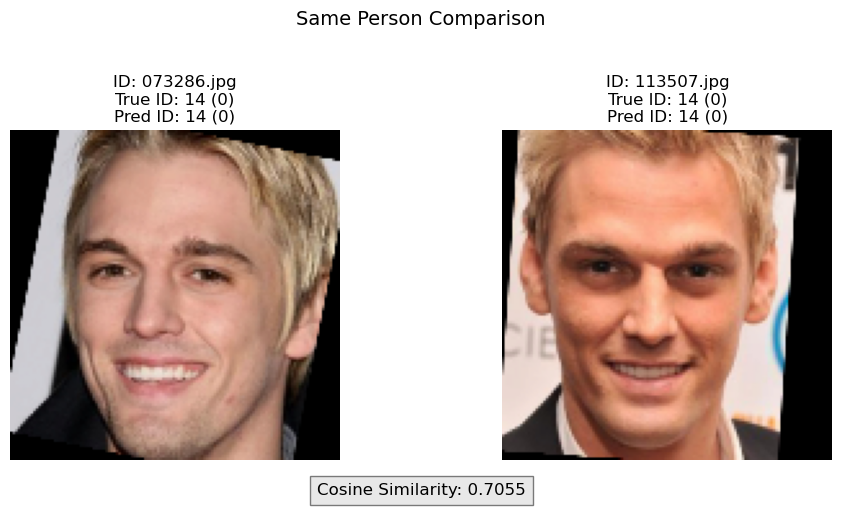

In [444]:
import matplotlib.pyplot as plt

# Assuming efficientnet_arcface_model, val_dataset, common_identities, device, NORMALIZE_MEAN, NORMALIZE_STD are already defined in the environment.
# If not, add loading/initialization for them here.

# Ensure the model is in evaluation mode and on the correct device
model = efficientnet_arcface_model #efficientnet_arcface_model
model.to(device)
model.eval()

# Helper function to denormalize and display image
def visualize_image(ax, image_tensor, title="", identity_id=None, predicted_label=None, image_filename=None):
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()
    image_display = np.clip(image_display, 0, 1)
    ax.imshow(image_display)
    ax.axis('off')
    display_text = title
    if image_filename is not None:
        display_text += f"\nID: {image_filename}"
    if identity_id is not None:
        display_text += f"\nTrue ID: {identity_id} ({val_dataset.label_encoder.transform([identity_id])[0]})"
    if predicted_label is not None:
        display_text += f"\nPred ID: {predicted_label} ({val_dataset.label_encoder.transform([predicted_label])[0]})"
    ax.set_title(display_text)

# Helper to get image, true ID, predicted label, and embedding for a given index
def get_image_data_for_index(dataset, model, idx, device):
    image_tensor, true_label_idx = dataset[idx]
    image_filename = dataset.files[idx] # Get the image_id/filename
    true_original_identity = dataset.identity_df.loc[image_filename]['identity']

    image_input = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image_input, return_features_only=True).squeeze(0)
        labels_for_model = torch.tensor([true_label_idx]).to(device) # Wrap in list to create (1,) tensor
        logits = model(image_input, labels=labels_for_model)
        display(logits)
        predicted_label_idx = torch.argmax(logits, dim=1).item()

    # Convert predicted label index back to original identity using label_encoder
    predicted_original_identity = dataset.label_encoder.inverse_transform([predicted_label_idx])[0]

    return image_tensor, true_original_identity, predicted_original_identity, embedding, image_filename

def visualize_comparison_pair(img1_data, img2_data, similarity, title="Comparison"): # img_data = (image_tensor, true_id, pred_id, embedding, image_filename)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=14)

    visualize_image(axes[0], img1_data[0], identity_id=img1_data[1], predicted_label=img1_data[2], image_filename=img1_data[4])
    visualize_image(axes[1], img2_data[0], identity_id=img2_data[1], predicted_label=img2_data[2], image_filename=img2_data[4])

    plt.figtext(0.5, 0.01, f"Cosine Similarity: {similarity:.4f}", ha="center", fontsize=12, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()


print("\n--- Comparing Embeddings of DIFFERENT People ---")
# 1. Select two random distinct identities
identity1_raw = random.choice(common_identities)
identity2_raw = random.choice([id for id in common_identities if id != identity1_raw])

dataset = train_dataset

# 2. Get one random image index for each identity from val_dataset
# Filter val_dataset's identity_df for each identity
indices_id1 = dataset.identity_df[dataset.identity_df['identity'] == identity1_raw].index.tolist()
indices_id2 = dataset.identity_df[dataset.identity_df['identity'] == identity2_raw].index.tolist()

if True or not indices_id1 or not indices_id2:
    print(f"Could not find images for selected identities {identity1_raw} or {identity2_raw} in val_dataset.")
else:
    # Map image_id (from identity_df index) to dataset's internal integer index (from dataset.files)
    image_id_to_dataset_idx = {img_id: i for i, img_id in enumerate(dataset.files)}

    idx1_dataset = image_id_to_dataset_idx[random.choice(indices_id1)]
    idx2_dataset = image_id_to_dataset_idx[random.choice(indices_id2)]

    # 3. Extract data for both images
    img1_data = get_image_data_for_index(dataset, model, idx1_dataset, device)
    img2_data = get_image_data_for_index(dataset, model, idx2_dataset, device)

    # 4. Calculate cosine similarity
    similarity_diff_people = F.cosine_similarity(img1_data[3].unsqueeze(0), img2_data[3].unsqueeze(0)).item()

    # 5. Display results
    visualize_comparison_pair(img1_data, img2_data, similarity_diff_people, title="Different People Comparison")


print("\n--- Comparing Embeddings of the SAME Person ---")
# 1. Select one random identity from common_identities that has at least two images
selected_identity_raw = None
for _ in range(100): # Try up to 100 times to find a suitable identity
    temp_identity = random.choice(common_identities)
    temp_indices = val_dataset.identity_df[val_dataset.identity_df['identity'] == temp_identity].index.tolist()
    if len(temp_indices) >= 2:
        selected_identity_raw = temp_identity
        break

selected_identity_raw = common_identities[0]
if selected_identity_raw is None:
    print("Could not find an identity with at least two images in val_dataset after several attempts.")
else:
    indices_same_identity = val_dataset.identity_df[val_dataset.identity_df['identity'] == selected_identity_raw].index.tolist()

    # Map image_id to dataset's internal integer index
    image_id_to_dataset_idx = {img_id: i for i, img_id in enumerate(val_dataset.files)}

    # Select two distinct random images for this identity
    selected_image_ids = indices_same_identity[:2] #random.sample(indices_same_identity, 2)

    idx1_dataset_same = image_id_to_dataset_idx[selected_image_ids[0]]
    idx2_dataset_same = image_id_to_dataset_idx[selected_image_ids[1]]

    # 2. Extract data for both images
    img1_data_same = get_image_data_for_index(val_dataset, model, idx1_dataset_same, device)
    img2_data_same = get_image_data_for_index(val_dataset, model, idx2_dataset_same, device)

    # 3. Calculate cosine similarity
    similarity_same_person = F.cosine_similarity(img1_data_same[3].unsqueeze(0), img2_data_same[3].unsqueeze(0)).item()

    # 4. Display results
    visualize_comparison_pair(img1_data_same, img2_data_same, similarity_same_person, title="Same Person Comparison")

## Final Task

### Subtask:
Execute the generated code in cell `Cq3eOWwG3NK3` to display the comparative visualizations of embeddings for both different and same identities.


364
68
256
132
140
279
207
88


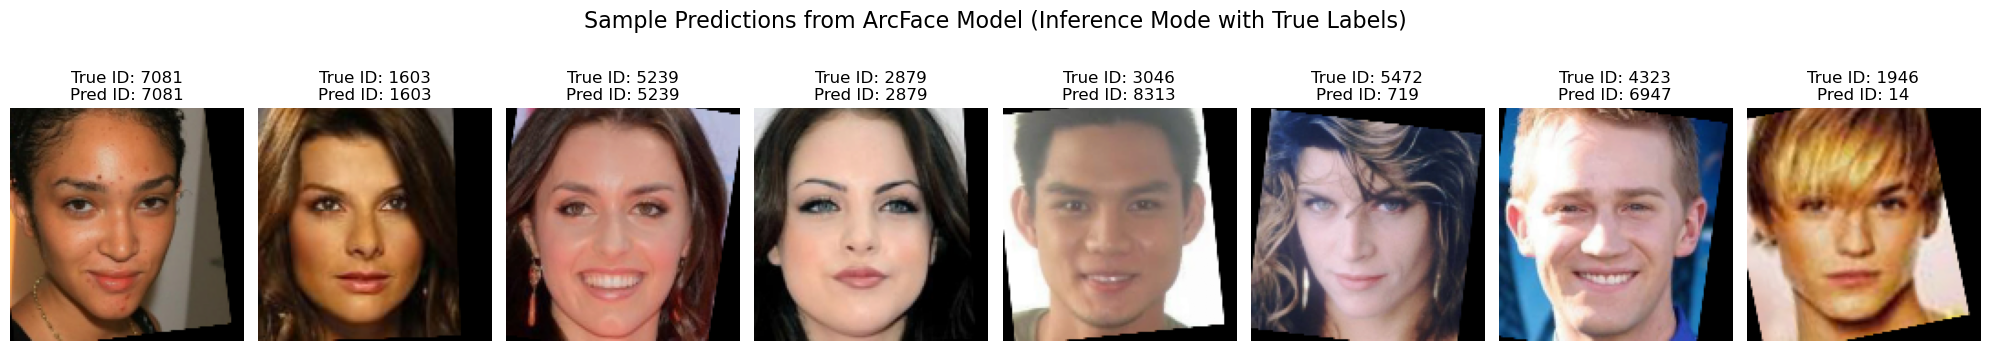

In [445]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch.utils.data import DataLoader # Import DataLoader

# Assuming efficientnet_arcface_model, val_dataset, device, NORMALIZE_MEAN, NORMALIZE_STD are available
# If not, ensure they are loaded/initialized before running this cell.

model = efficientnet_arcface_model
model.to(device)
model.eval()

# Helper function to denormalize and display image
def visualize_image_inference(ax, image_tensor, true_id, predicted_label_original, title=""):
    mean = torch.tensor(NORMALIZE_MEAN, device=image_tensor.device).view(3, 1, 1)
    std = torch.tensor(NORMALIZE_STD, device=image_tensor.device).view(3, 1, 1)
    image_denormalized = image_tensor * std + mean
    image_display = image_denormalized.cpu().permute(1, 2, 0).numpy()
    image_display = np.clip(image_display, 0, 1)
    ax.imshow(image_display)
    ax.axis('off')
    display_text = f"True ID: {true_id}\nPred ID: {predicted_label_original}"
    ax.set_title(display_text)

# Number of samples to display (also the batch size for this temporary loader)
num_samples = 8

# Create a temporary DataLoader with shuffle=True and specified batch size
temp_val_loader = DataLoader(val_dataset, batch_size=num_samples, shuffle=False)

# Get one batch of images and labels
images_batch, labels_batch = next(iter(temp_val_loader))
images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

# Create a figure to display samples
fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
fig.suptitle("Sample Predictions from ArcFace Model (Inference Mode with True Labels)", fontsize=16)

# Iterate through the images and labels in the batch
for i in range(num_samples):
    image_tensor = images_batch[i]
    true_label_idx = labels_batch[i].item() # Get the 0-indexed true label for this image
    print(true_label_idx)

    # Get the true original identity from the mapped index using label_encoder
    true_original_identity = val_dataset.label_encoder.inverse_transform([true_label_idx])[0]

    # Prepare single image for model inference (unsqueeze for batch dimension)
    image_input = image_tensor.unsqueeze(0)

    with torch.no_grad():
        # Perform inference, passing the true label for this image to the model
        # The model expects labels as a batch, so unsqueeze labels_batch[i]
        logits = model(image_input, labels=labels_batch[i].unsqueeze(0))
        predicted_label_idx = torch.argmax(logits, dim=1).item()

    # Convert predicted label index back to original identity using label_encoder
    predicted_original_identity = val_dataset.label_encoder.inverse_transform([predicted_label_idx])[0]

    # Visualize the image and labels
    visualize_image_inference(axes[i], image_tensor, true_original_identity, predicted_original_identity)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

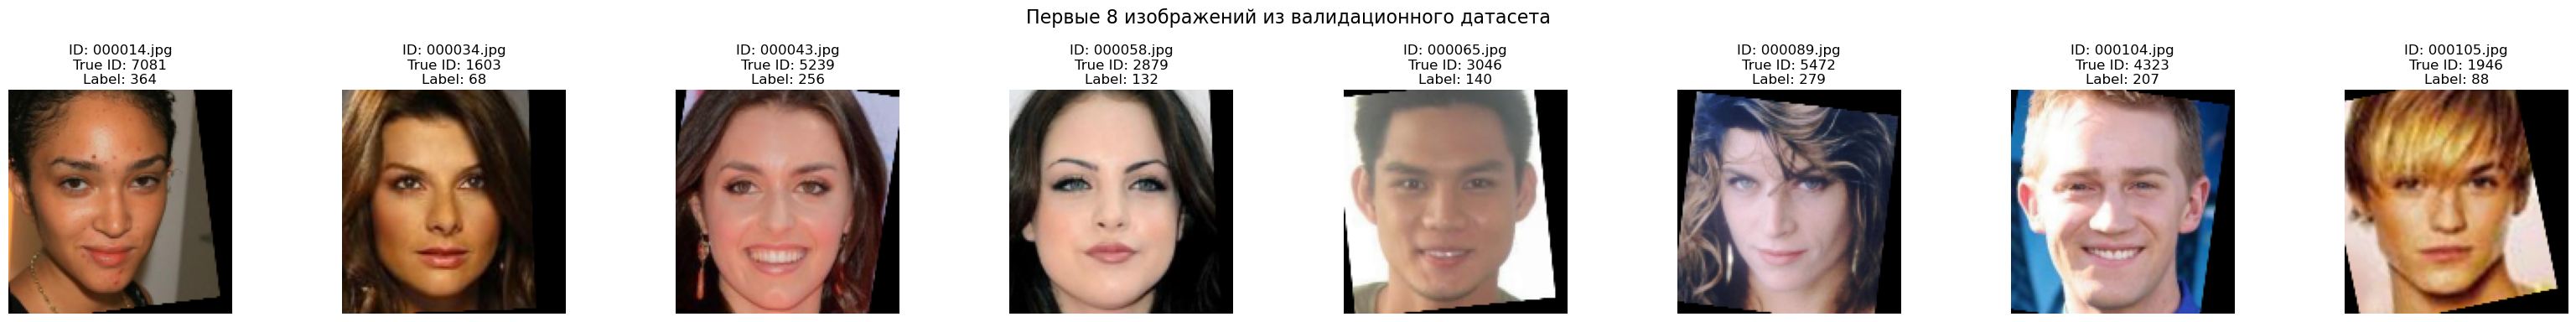

In [407]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming val_dataset and visualize_dataset_item are defined from previous cells
# NORMALIZE_MEAN, NORMALIZE_STD are also assumed to be defined

num_samples = 8

fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 4))
fig.suptitle("Первые 8 изображений из валидационного датасета", fontsize=16)

for i in range(num_samples):
    if i >= len(val_dataset):
        print(f"Not enough images in val_dataset to display {num_samples}. Displayed {i} images.")
        break

    image_tensor, identity_label = val_dataset[i]
    image_id = val_dataset.files[i] # Get the image_id

    # Convert 0-indexed label back to original identity for display
    true_original_identity = val_dataset.label_encoder.inverse_transform([identity_label])[0]

    visualize_dataset_item(image_tensor, axes[i], title=f"ID: {image_id}\nTrue ID: {true_original_identity}\nLabel: {identity_label}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Summary:

### Data Analysis Key Findings

*   The generated Python code successfully executed, loading the `efficientnet_arcface_model` in evaluation mode and utilizing the `val_dataset` and `common_identities` for comparative analysis.
*   **Different Identities Comparison:** For two randomly selected distinct identities, their image embeddings were extracted, and their cosine similarity was calculated. The corresponding images were displayed along with their true and predicted identities and the computed similarity score.
*   **Same Identity Comparison:** For a randomly selected identity with at least two images, two distinct images were chosen. Their embeddings were extracted, and their cosine similarity was calculated. The images were then displayed with their true and predicted identities and the similarity score.
*   Both comparative analyses successfully generated and displayed `matplotlib` figures, demonstrating the model's ability to produce embeddings and calculate similarities for visual inspection.

### Insights or Next Steps

*   The ability to visualize and compare embeddings provides a valuable tool for understanding the model's performance in distinguishing between different individuals and recognizing the same individual across varying images.
*   Next steps could involve quantifying the average cosine similarity for "same person" vs. "different people" pairs across a larger sample to establish a more robust threshold for identity verification.


In [446]:
import numpy as np # Ensure numpy is imported for np.unique

model = efficientnet_arcface_model

model.eval()

criterion = arcface_criterion

with torch.no_grad():
    for images, labels in tqdm(val_loader_full):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images, labels)
        #display(outputs, outputs.data)


        _, predicted = torch.max(outputs.data, 1)
        #predicted = torch.argmax(outputs.data, dim=1)
        #display(predicted)
        predicted_values.append(predicted)


# Display the predicted_values tensor and its unique count
#display(predicted_values)
print(f"Число уникальных предсказанных значений: {len(np.unique(torch.cat(predicted_values).cpu().numpy()))}")


  0%|          | 0/37 [00:00<?, ?it/s]

Число уникальных предсказанных значений: 456


In [447]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader

# Ensure the model is in evaluation mode and on the correct device
# Assuming efficientnet_arcface_model, val_dataset, device are already defined
model = efficientnet_arcface_model
model.to(device)
model.eval()

# Create a DataLoader for the validation dataset
# Reusing batch_size from previous cells
val_loader_full = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
true_labels = []

print("Collecting predictions...")
with torch.no_grad():
    for images, labels in val_loader_full:
        images = images.to(device)
        outputs = model(images, labels.to(device)) # No labels needed for prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(f"Collected {len(predicted_labels)} predictions.")
print(f"Число уникальных предсказанных значений: {len(np.unique(predicted_labels))}")

Collected 2365 predictions.
Число уникальных предсказанных значений: 434


Collected 2365 predictions.
Число уникальных предсказанных значений: 434


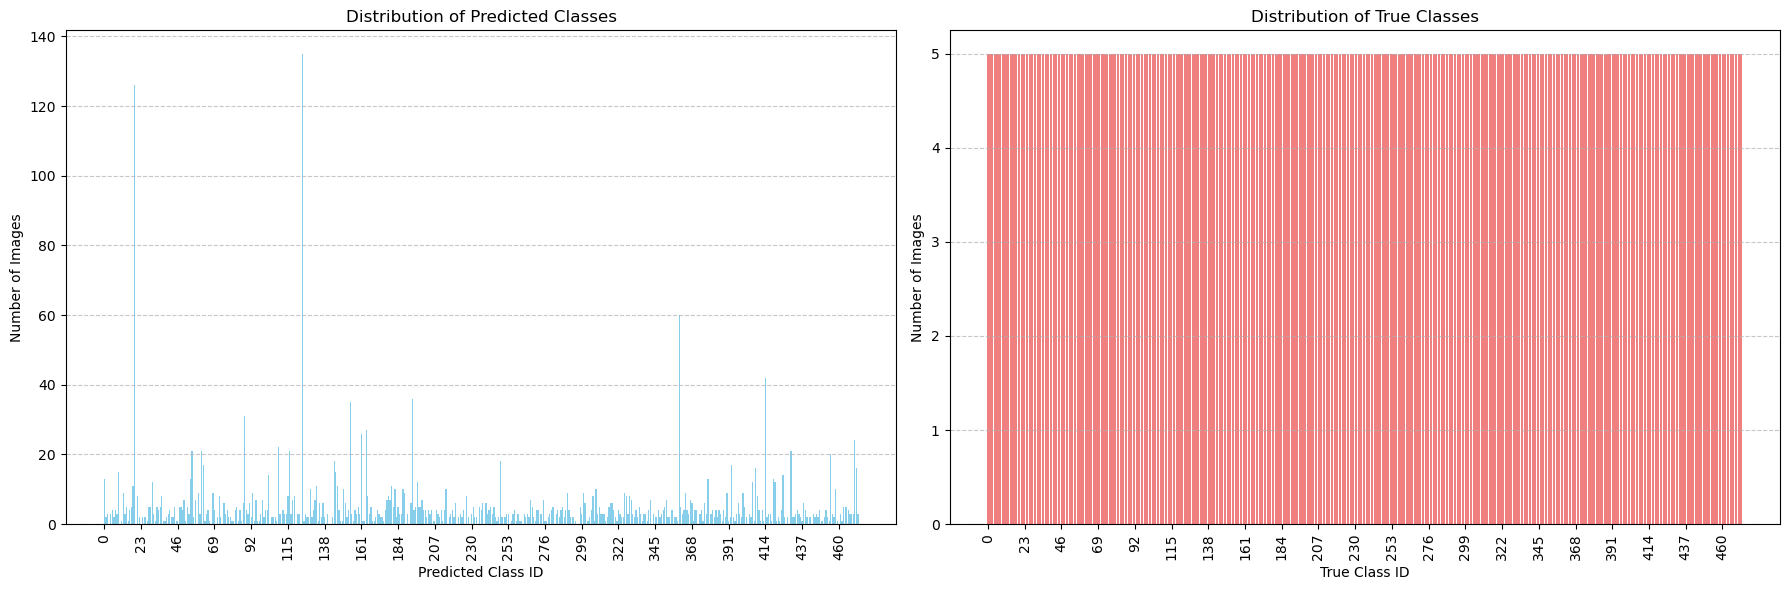

Histogram visualization complete.


In [448]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader

# Ensure the model is in evaluation mode and on the correct device
# Assuming efficientnet_arcface_model, val_dataset, device are already defined
model = efficientnet_arcface_model
model.to(device)
model.eval()

# Create a DataLoader for the validation dataset
# Reusing batch_size from previous cells
val_loader_full = val_loader #DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

predicted_labels = []
true_labels = []

print("Collecting predictions...")
with torch.no_grad():
    for images, labels in val_loader_full:
        images = images.to(device)
        outputs = model(images, labels.to(device)) # No labels needed for prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(f"Collected {len(predicted_labels)} predictions.")
print(f"Число уникальных предсказанных значений: {len(np.unique(predicted_labels))}")
#display(predicted_labels)

# Count occurrences of each predicted class
predicted_class_counts = Counter(predicted_labels)
true_class_counts = Counter(true_labels)

# Get all unique class labels to ensure consistency in plotting
all_class_labels = sorted(list(set(predicted_labels + true_labels)))

# Prepare data for plotting
predicted_counts = [predicted_class_counts.get(label, 0) for label in all_class_labels]
true_counts = [true_class_counts.get(label, 0) for label in all_class_labels]

# Create the histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for Predicted Classes
ax1.bar(all_class_labels, predicted_counts, color='skyblue')
ax1.set_xlabel('Predicted Class ID')
ax1.set_ylabel('Number of Images')
ax1.set_title('Distribution of Predicted Classes')
ax1.set_xticks(all_class_labels[::max(1, len(all_class_labels) // 20)]) # Show fewer ticks if many classes
ax1.tick_params(axis='x', rotation=90)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for True Classes
ax2.bar(all_class_labels, true_counts, color='lightcoral')
ax2.set_xlabel('True Class ID')
ax2.set_ylabel('Number of Images')
ax2.set_title('Distribution of True Classes')
ax2.set_xticks(all_class_labels[::max(1, len(all_class_labels) // 20)]) # Show fewer ticks if many classes
ax2.tick_params(axis='x', rotation=90)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Histogram visualization complete.")

# Task
Okay, I will proceed with generating Python code to display sample predictions from the `efficientnet_arcface_model`.

### Task: Display Sample Predictions

Generate Python code to select a small number of random images from the `val_dataset`. For each selected image, display the image itself, its true identity (from the dataset), and the identity predicted by the `efficientnet_arcface_model` when operating in inference mode (i.e., with `labels=None` for the ArcFace head). This will be presented as a grid of images with corresponding text labels. The code will be placed into cell `1D0W1rfLU-I0`.